<a href="https://colab.research.google.com/github/chitra-psg/house_price_prediction/blob/main/house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [346]:
# Import the required modules
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Adding a constant variable 
import statsmodels.api as sm  
#%matplotlib inline

# Configurations
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# **Common Functions**

In [347]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):  
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=10)
  chrt.set_xlabel(xlabel,fontsize=10)
  chrt.set_ylabel(ylabel,fontsize=10) 

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner. 
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [348]:
# Function for Analysis of Numerical column
def AnalyseNumericalColumns(df_data, i, col_i,col_o):
    plt.figure(i)
    sns.jointplot(x=col_i, y=col_o, data=df_data[[col_i,col_o]])

In [349]:
# Function for Analysis of Categorical column
def AnalyseCategoricalColumns(df_data, i, col_i,col_o):
    plt.figure(i)
    variables = df_data[[col_i]].nunique()
    plt.figure(figsize=(variables,variables/1.77))
    my_order = df_data[[col_i,col_o]].groupby(by=[col_i])[col_o].median().sort_values(ascending=True)
    sns.boxplot(x=col_i, y=col_o, data=df_data[[col_i,col_o]], order=my_order.index)

In [350]:
# Function to calcualte VIF 
def GetVIF(X):
  vif = pd.DataFrame()
  X = X.drop(['const'], axis=1)
  vif['Features'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  return vif

In [351]:
# Function to create linear regession model and fit it.
def GetLinearRegression(X_train, y_train):
    # Add a constant
    X_train_lm = sm.add_constant(X_train)
    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    return lr

In [352]:
# A function has been created to map the actual numbers to categorical levels.

# Assigning string values to different months instead of numeric values which may misindicate some order to it.
def MapMonths(x):
    return x.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'})


In [353]:
def CreateLRModel(df_X_train, df_y_train, lst_columns):
  # Creating X_test dataframe with RFE selected variables
  df_X_train_rfe = df_X_train[lst_columns] 
  df_X_train_rfe = sm.add_constant(df_X_train_rfe)
  # Running the linear model
  lm = sm.OLS(df_y_train, df_X_train_rfe).fit()
  # Calculate VIF to check for multi collinearity
  vif = pd.DataFrame()
  df_X = df_X_train_rfe.drop(['const'], axis=1)
  vif['Features'] = df_X.columns
  vif['VIF'] = [variance_inflation_factor(df_X.values, i) for i in range(df_X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  #Let's see the summary of our linear model
  print(lm.summary())
  #Let's view the summary of VIF 
  print(vif)
  return lm

# **Data Preparation**

In [354]:
# Load the source data from GitHub into dataframe for analysis
# Load all column data in and then determine data type : low_memory=False
df_house = pd.read_csv("https://github.com/chitra-psg/house_price_prediction/blob/main/train.csv?raw=True",  low_memory=False)
df_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [355]:
# Check data types of fields
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [356]:
# Check for NULLs
df_house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [357]:
# Convert few categorical fields to object data type
df_house[['MSSubClass', 'OverallQual', 'OverallCond']] = df_house[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')

In [358]:
# Dropping Columns with more than 15 % missing values
#min_count = df_house.shape[0] * 0.85
#df_house.dropna( axis=1, thresh=min_count)
# Dropping Columns with more than 15 % missing values
#df_house.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'LotFrontage'], axis=1, inplace=True)
#print(((df_house.isnull().sum()/ df_house.shape[0])*100).round(2))

In [359]:
df_house.describe()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [360]:
# Check for NULLs
df_house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [361]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   object 
 18  OverallC

In [362]:
#Cateforical fields with NA to be filled with None
col_NA_none = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

df_house.loc[:, col_NA_none] = df_house.loc[:, col_NA_none].fillna('None')

#Numerical fields with NA to be filled with 0
col_NA_num = ['GarageYrBlt']
df_house.loc[:, col_NA_num] = df_house.loc[:, col_NA_num].fillna(0)

In [363]:
#Check for NULLs again
df_house.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath 

In [364]:
## Create new column for the age of the house
df_house['AgeOfHouseWhenSold'] = df_house['YrSold'] - df_house['YearBuilt']

In [365]:
## Drop the two columns from which we created new one
df_house.drop(['YrSold', 'YearBuilt','Id'], axis=1, inplace=True)

In [366]:
print(df_house.shape)

(1460, 79)


In [367]:
#Check for NULLs again
df_house.isnull().sum()

MSSubClass              0
MSZoning                0
LotFrontage           259
LotArea                 0
Street                  0
Alley                   0
LotShape                0
LandContour             0
Utilities               0
LotConfig               0
LandSlope               0
Neighborhood            0
Condition1              0
Condition2              0
BldgType                0
HouseStyle              0
OverallQual             0
OverallCond             0
YearRemodAdd            0
RoofStyle               0
RoofMatl                0
Exterior1st             0
Exterior2nd             0
MasVnrType              0
MasVnrArea              8
ExterQual               0
ExterCond               0
Foundation              0
BsmtQual                0
BsmtCond                0
BsmtExposure            0
BsmtFinType1            0
BsmtFinSF1              0
BsmtFinType2            0
BsmtFinSF2              0
BsmtUnfSF               0
TotalBsmtSF             0
Heating                 0
HeatingQC   

In [368]:
# LotFrontage and GarageYrBuilt has Nulls.
# GarageYrBuilt has Null when the house doesnt have garage. We will address this when we derive feature
col_impute_mean = ['MasVnrArea', 'LotFrontage']
#Technique 1: Using mean to impute the missing values
for i in col_impute_mean:
  df_house.loc[df_house.loc[:,i].isnull(),i]=df_house.loc[:,i].mean()


In [369]:
# Checking for percentage of missing values per column
print(df_house.shape)
print(((df_house.isnull().sum()/df_house.shape[0])*100).round(2))

(1460, 79)
MSSubClass            0.0
MSZoning              0.0
LotFrontage           0.0
LotArea               0.0
Street                0.0
Alley                 0.0
LotShape              0.0
LandContour           0.0
Utilities             0.0
LotConfig             0.0
LandSlope             0.0
Neighborhood          0.0
Condition1            0.0
Condition2            0.0
BldgType              0.0
HouseStyle            0.0
OverallQual           0.0
OverallCond           0.0
YearRemodAdd          0.0
RoofStyle             0.0
RoofMatl              0.0
Exterior1st           0.0
Exterior2nd           0.0
MasVnrType            0.0
MasVnrArea            0.0
ExterQual             0.0
ExterCond             0.0
Foundation            0.0
BsmtQual              0.0
BsmtCond              0.0
BsmtExposure          0.0
BsmtFinType1          0.0
BsmtFinSF1            0.0
BsmtFinType2          0.0
BsmtFinSF2            0.0
BsmtUnfSF             0.0
TotalBsmtSF           0.0
Heating               0.0
H

In [370]:
df_X_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSSubClass          1460 non-null   object 
 1   MSZoning            1460 non-null   object 
 2   LotFrontage         1460 non-null   float64
 3   LotArea             1460 non-null   int64  
 4   Street              1460 non-null   object 
 5   Alley               1460 non-null   object 
 6   LotShape            1460 non-null   object 
 7   LandContour         1460 non-null   object 
 8   Utilities           1460 non-null   object 
 9   LotConfig           1460 non-null   object 
 10  LandSlope           1460 non-null   object 
 11  Neighborhood        1460 non-null   object 
 12  Condition1          1460 non-null   object 
 13  Condition2          1460 non-null   object 
 14  BldgType            1460 non-null   object 
 15  HouseStyle          1460 non-null   object 
 16  Overal

In [371]:
# Separating numerical and categorical fields for analysisng them separately using the provided Data Dictionary.

# OUTCOME COLUMN:
col_y = 'SalePrice'

df_X_house = df_house.drop("SalePrice" ,axis= 1)

# NUMERICAL COLUMNS: 
#col_X_numeric = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
#                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
#                 'MiscVal', 'MoSold','AgeOfHouseWhenSold']
#print(len(col_X_numeric))

# CATEGORICAL COLUMNS: 
#col_X_category = ['MSSubClass', 'MSZoning', 'Street',  'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
#           'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
#           'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
#           'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional','GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']
#print(len(col_X_category))

col_X_category = df_X_house.select_dtypes(include=['object']).columns
col_X_numeric = df_X_house.select_dtypes(include=['int64','float64']).columns

print(col_X_category,'\n',col_X_numeric,'\n')

# Listing distinct variables for each Categorical columns to address issues if any
for col in col_X_category:
    print(col,' : ',df_house[col].unique())

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'], dtype='object') 
 Index(['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'Ope

# **Exploratory Data Analysis**

LotFrontage
LotArea
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
AgeOfHouseWhenSold


<Figure size 640x480 with 0 Axes>

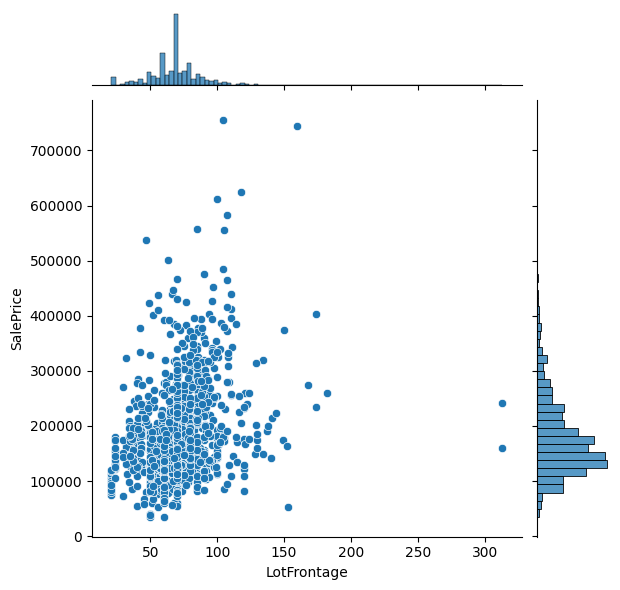

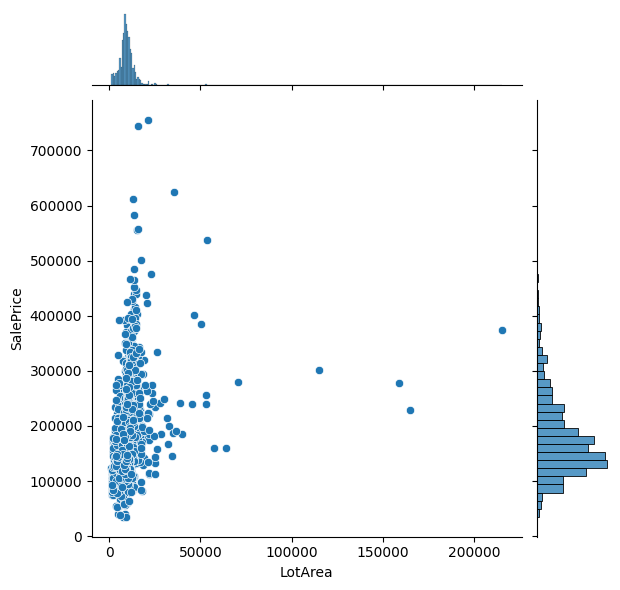

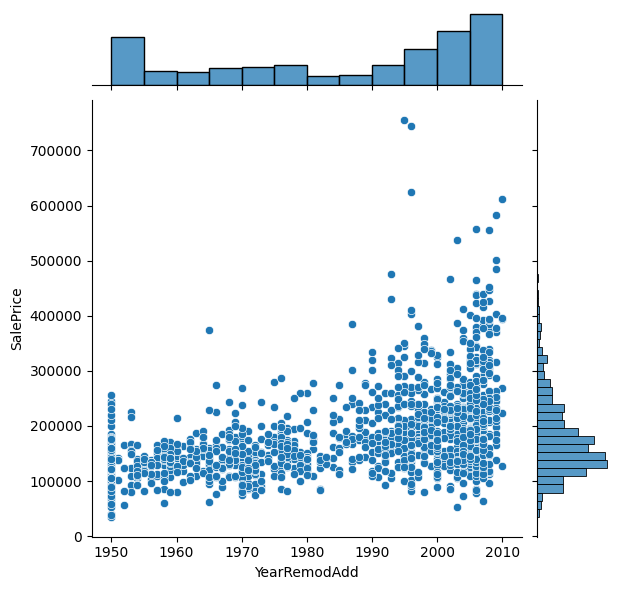

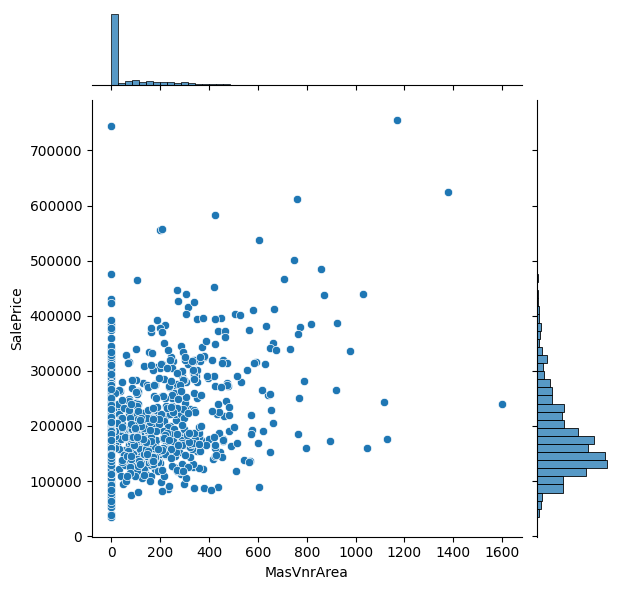

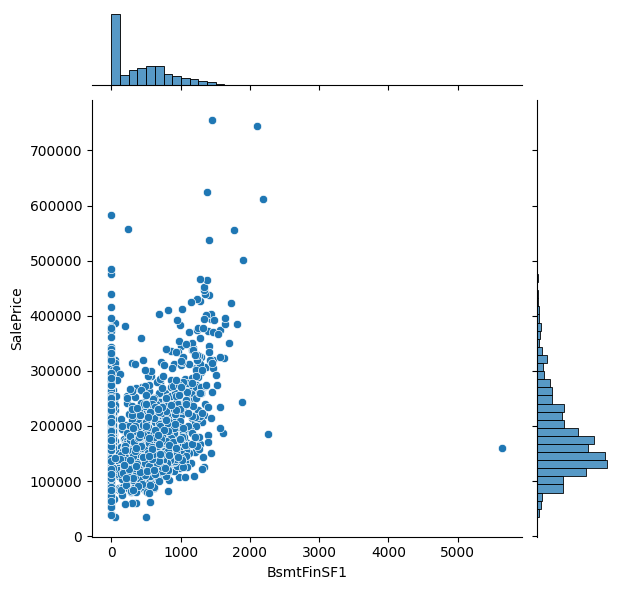

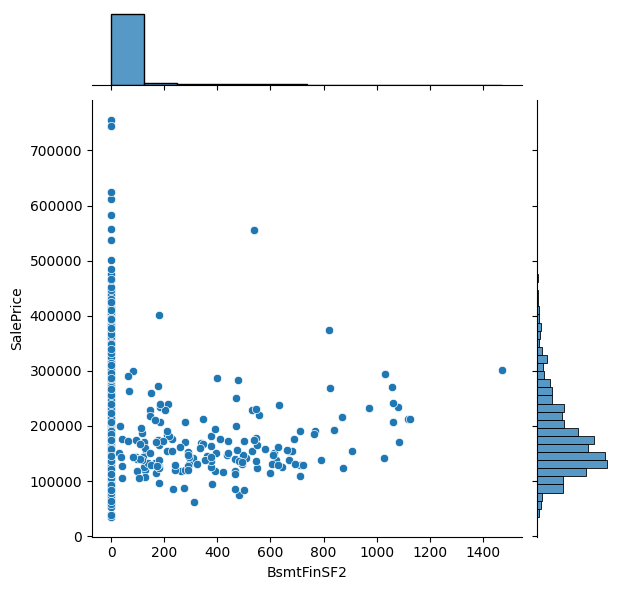

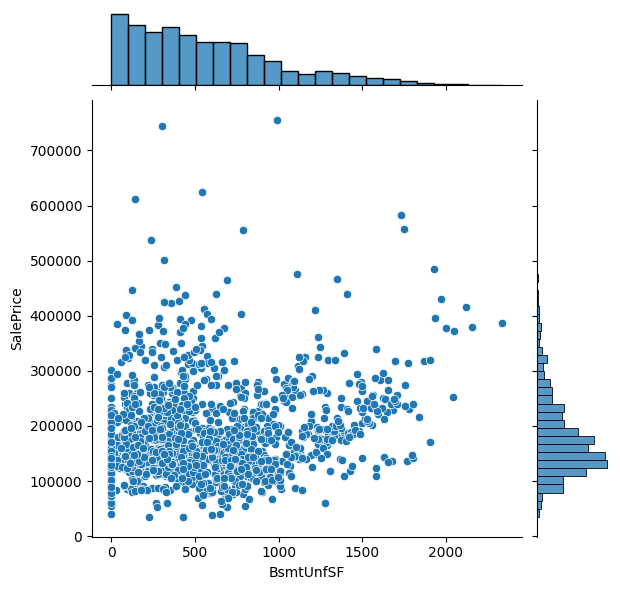

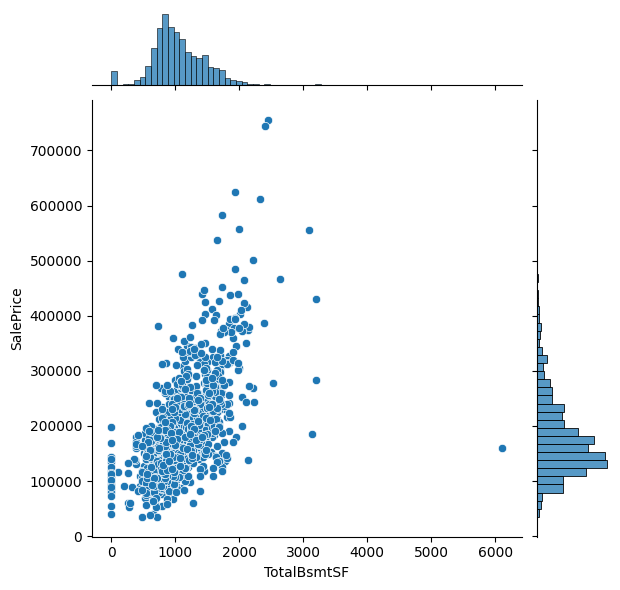

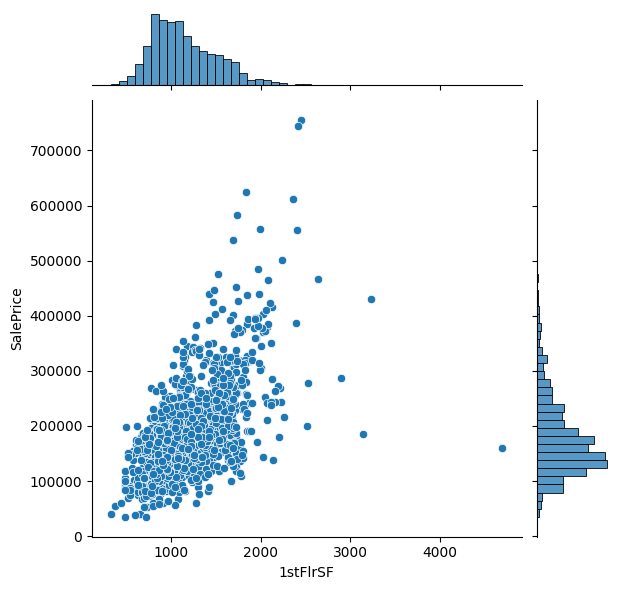

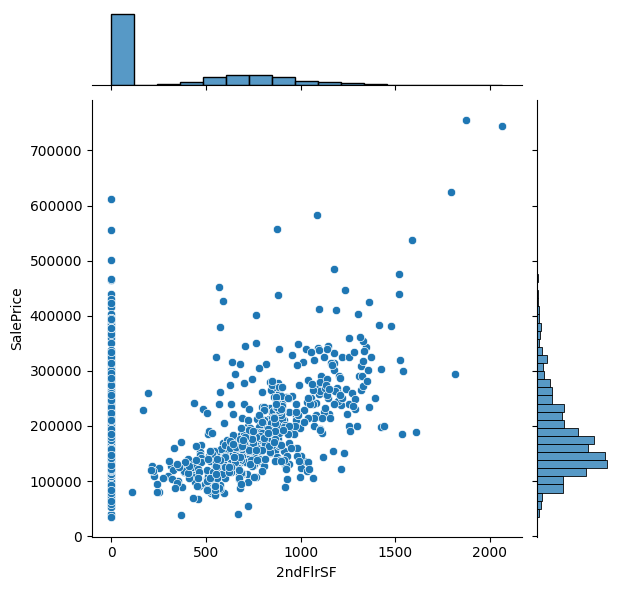

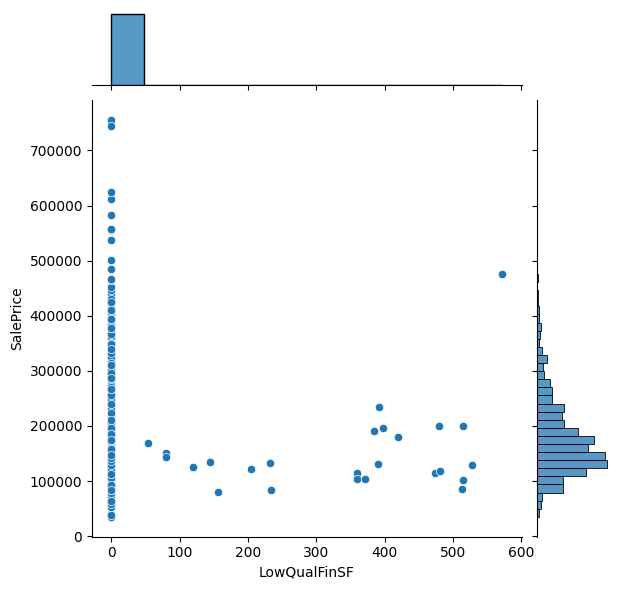

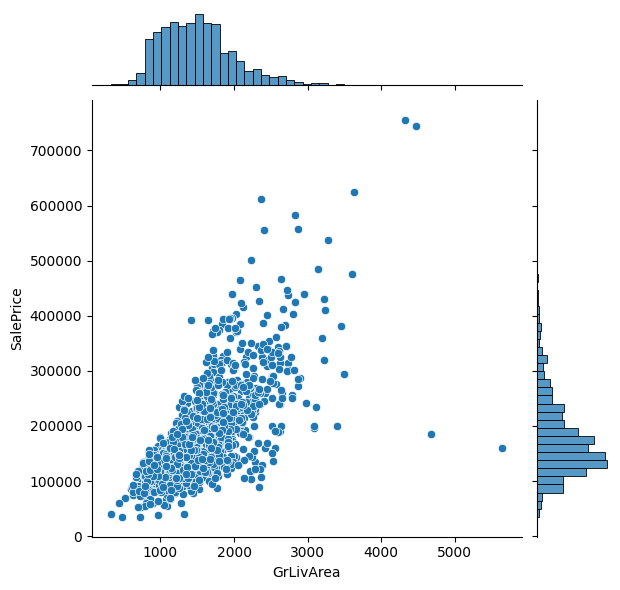

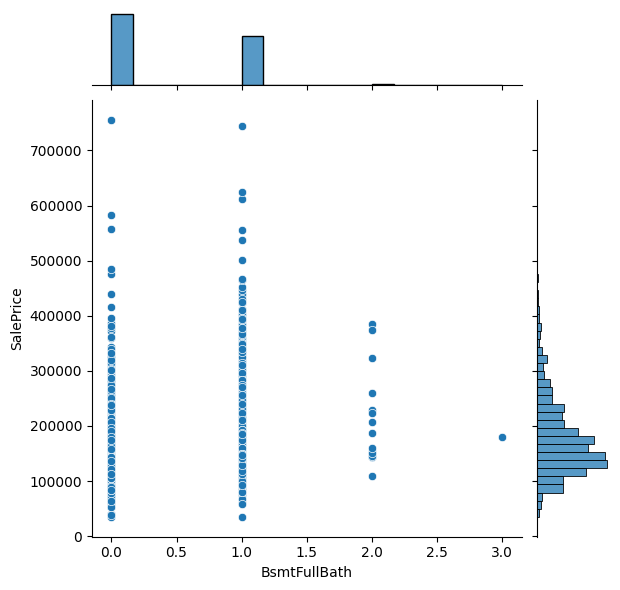

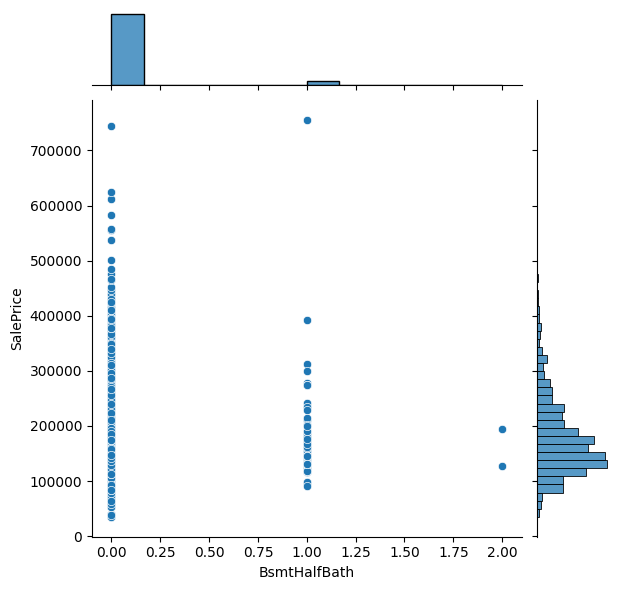

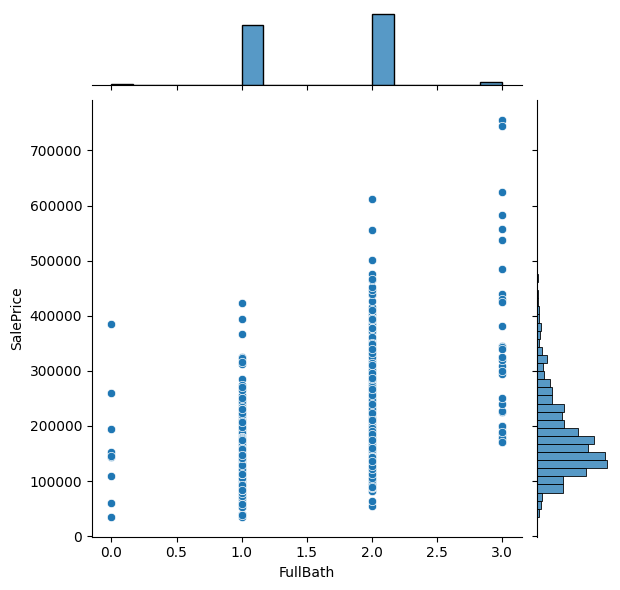

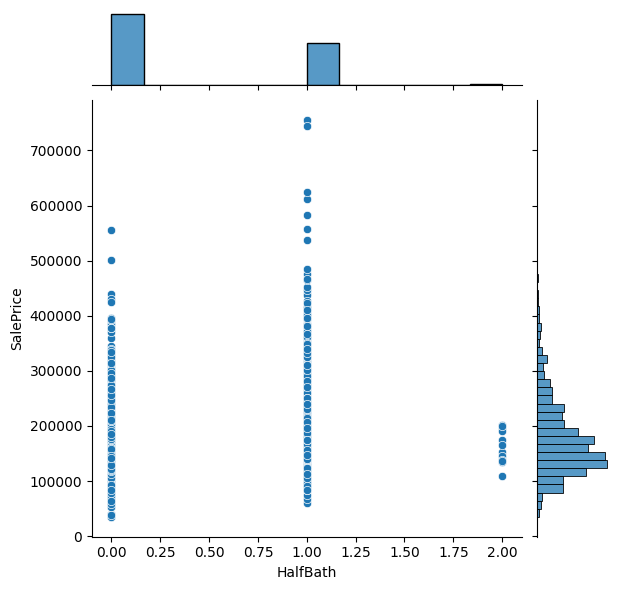

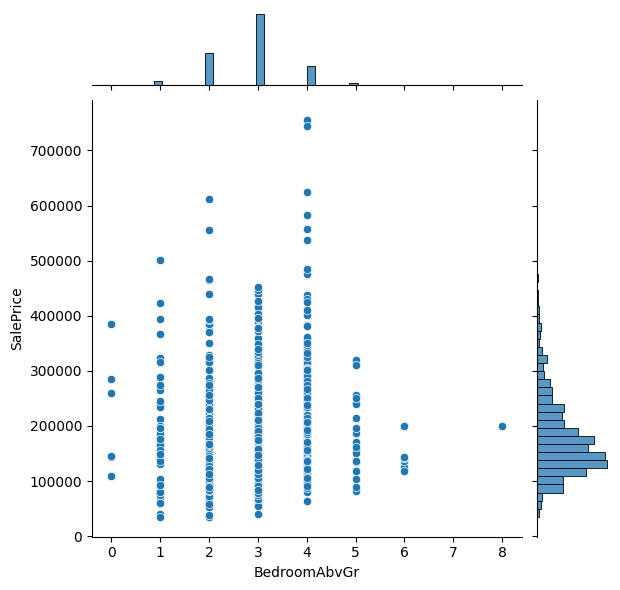

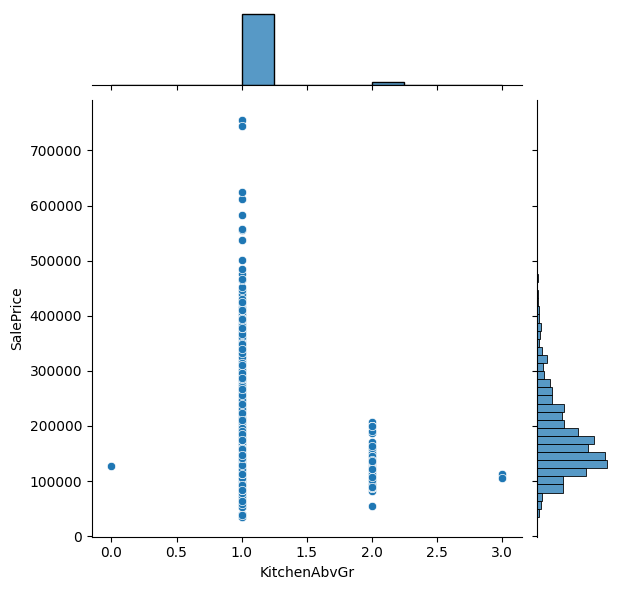

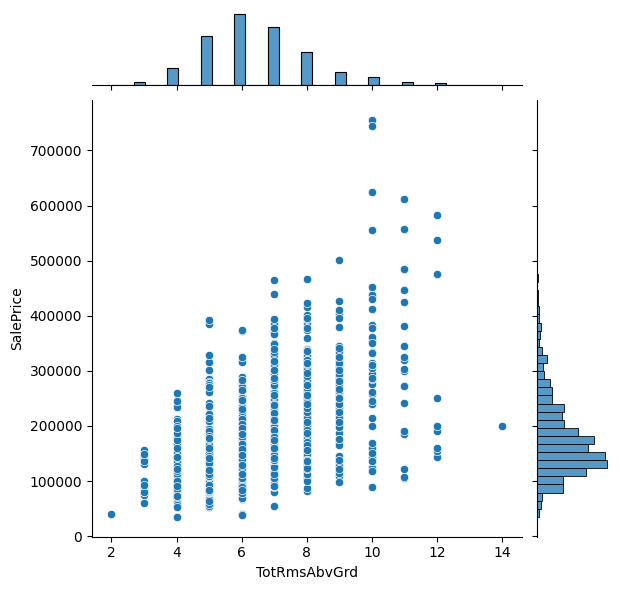

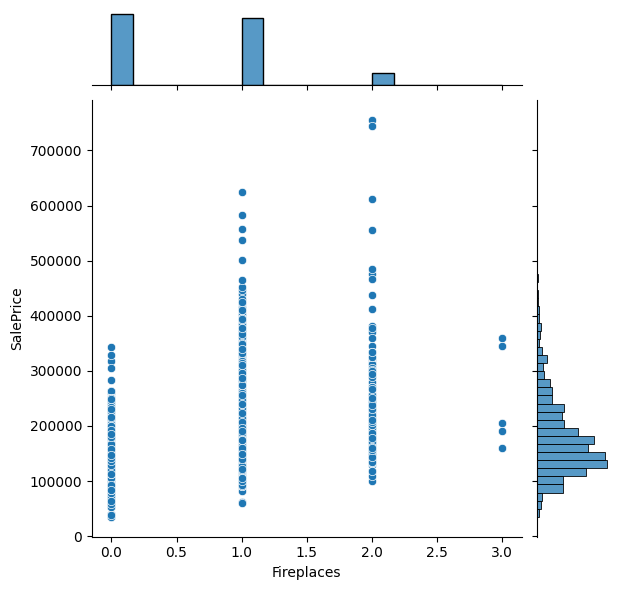

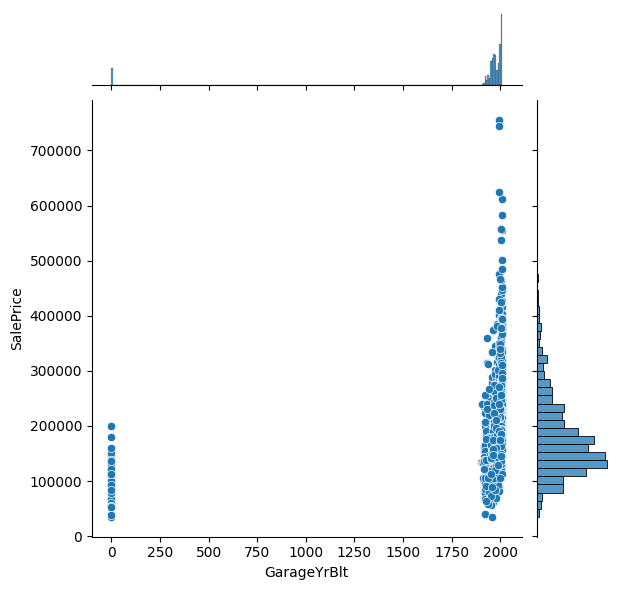

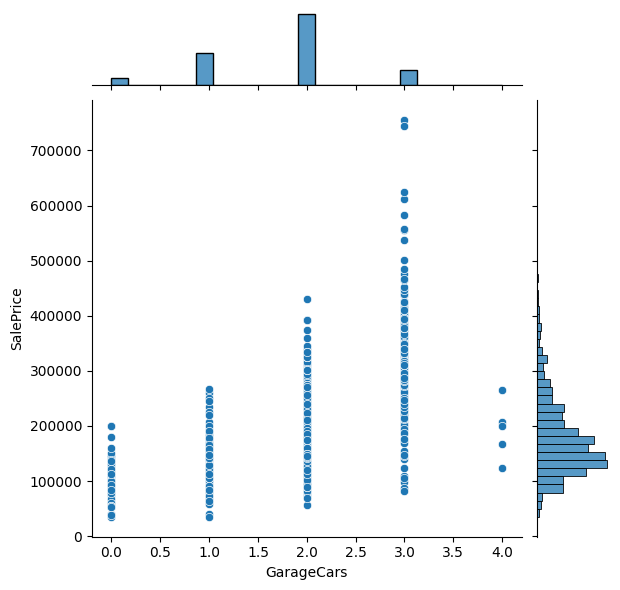

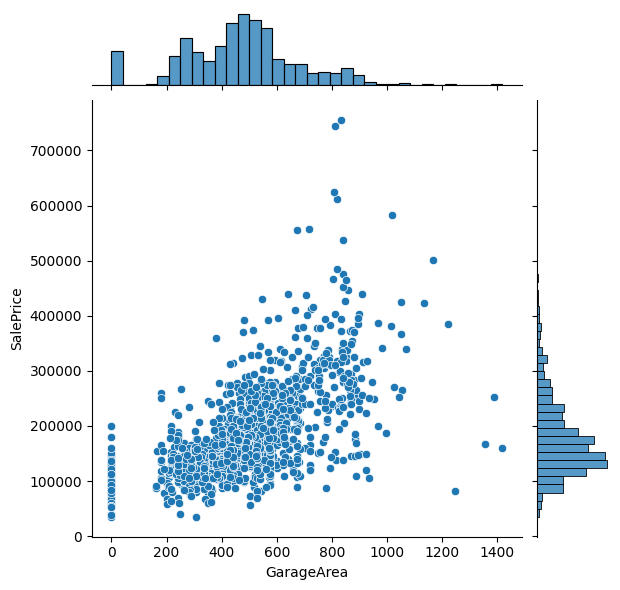

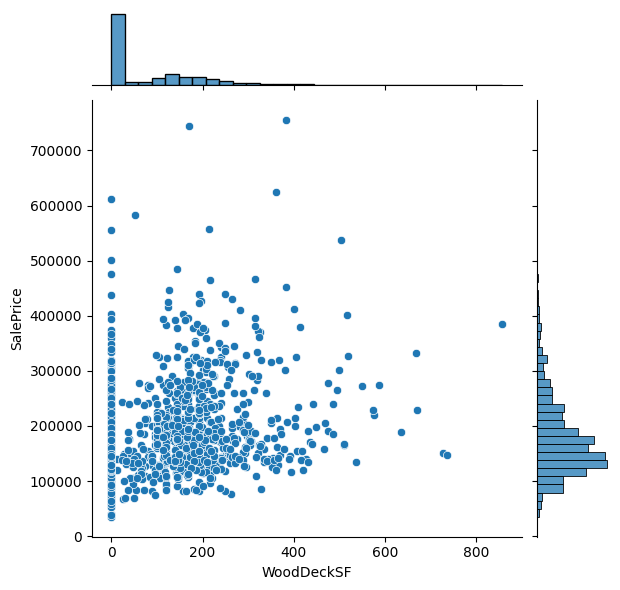

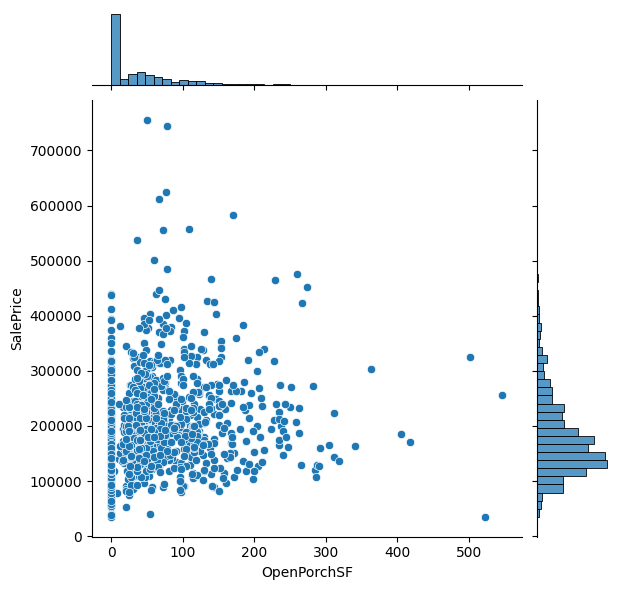

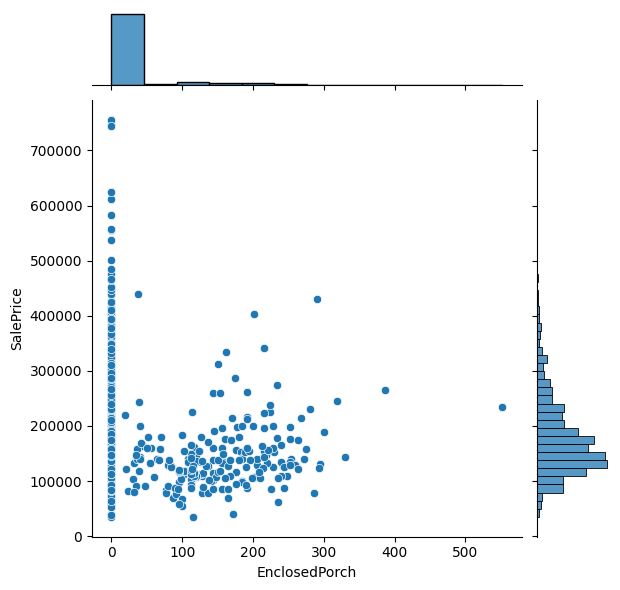

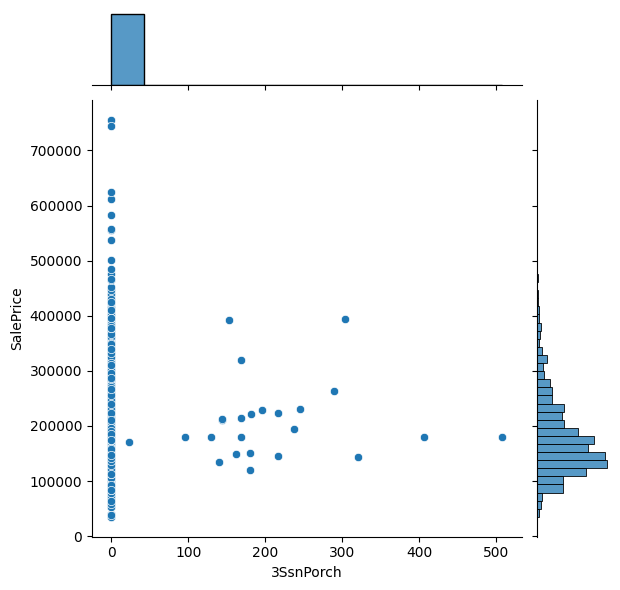

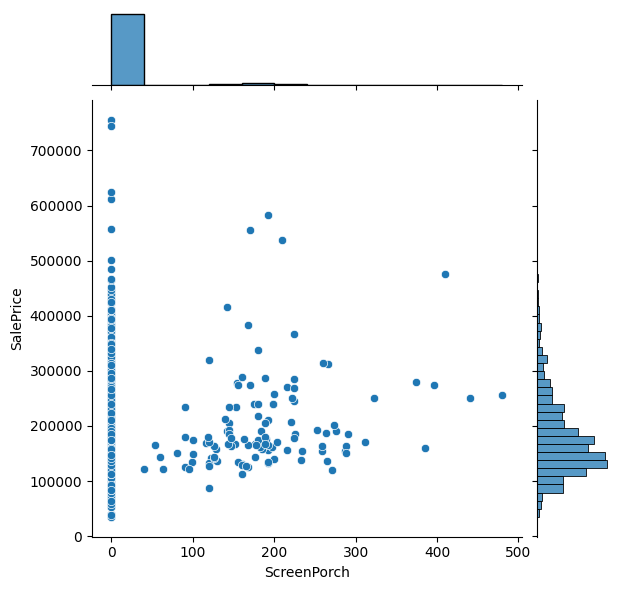

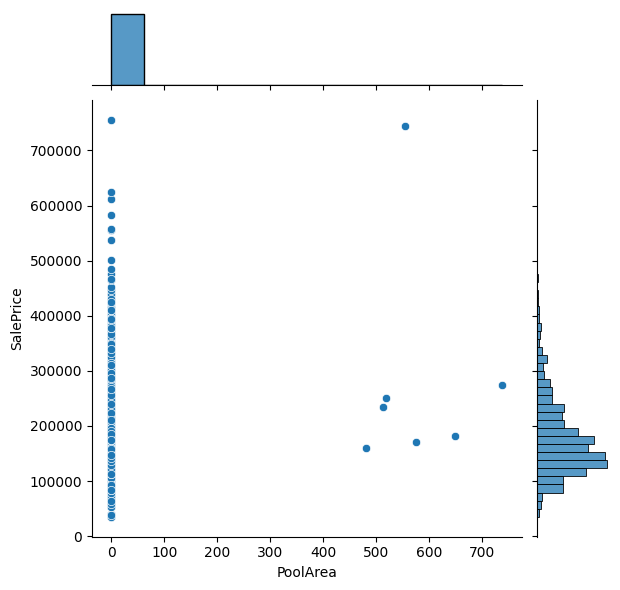

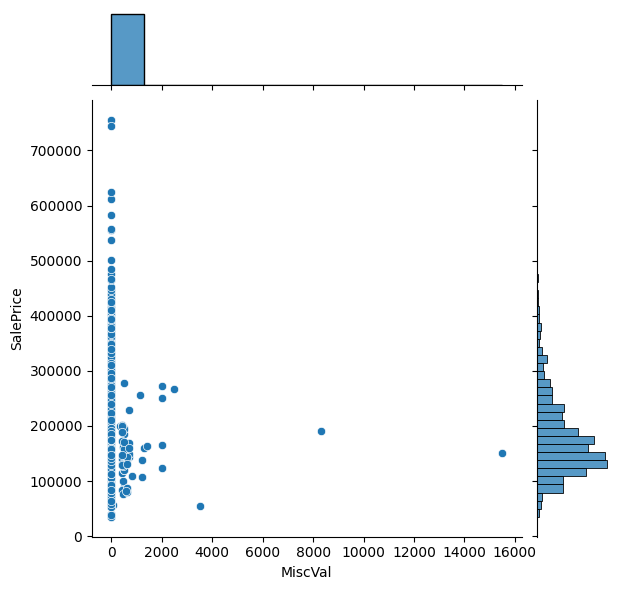

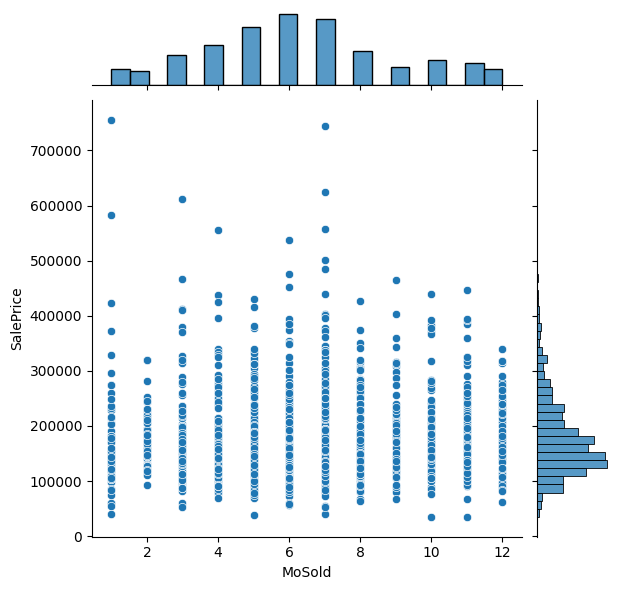

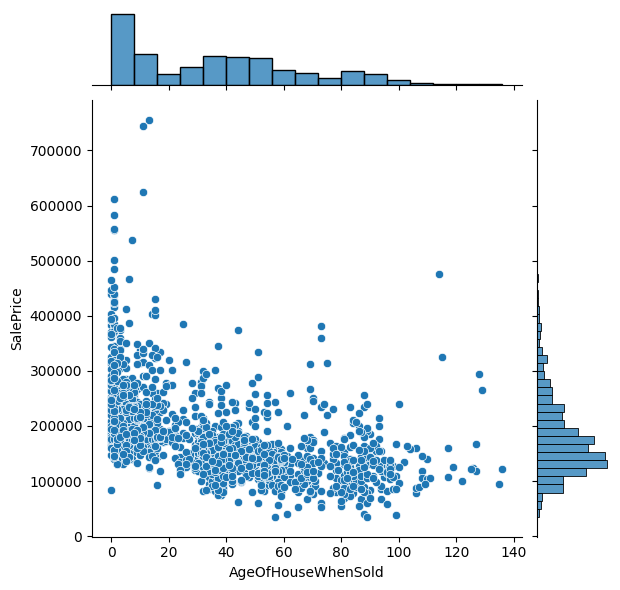

In [372]:
# NUMERICAL COLUMN ANALYSIS
for i, col in enumerate(col_X_numeric):
    print(col)
    AnalyseNumericalColumns(df_house, i, col, col_y)

<Figure size 640x480 with 0 Axes>

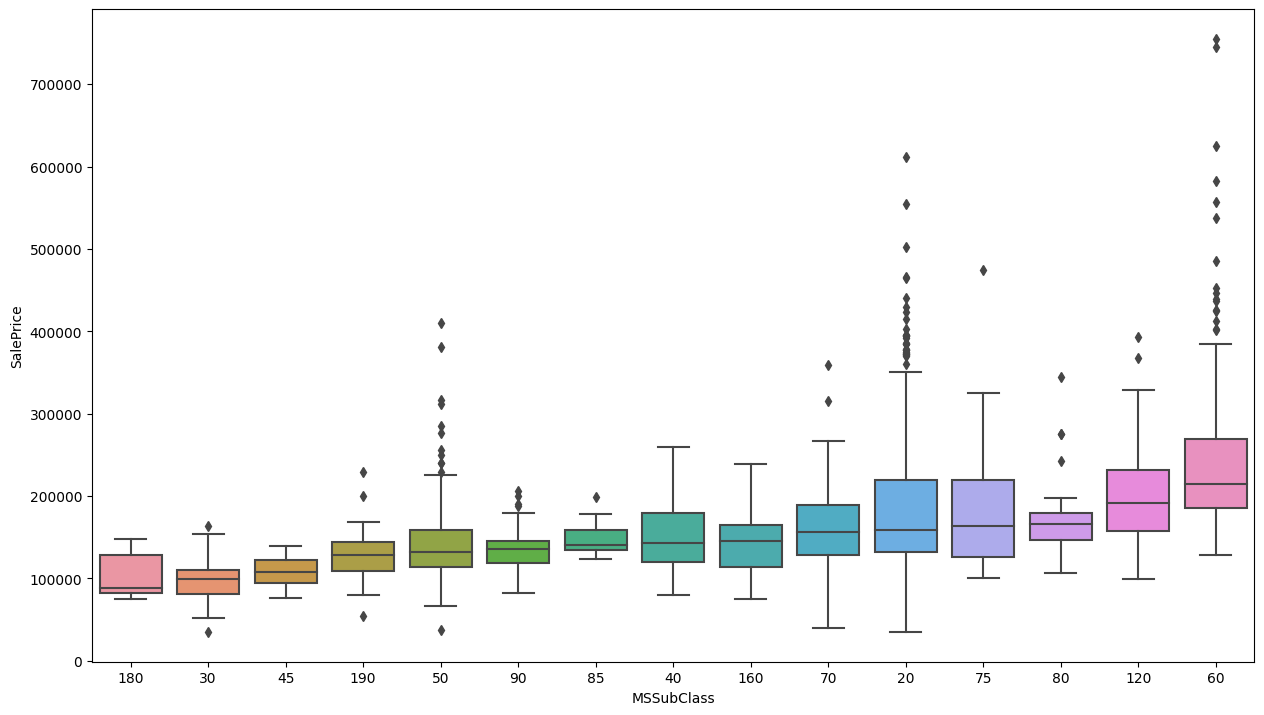

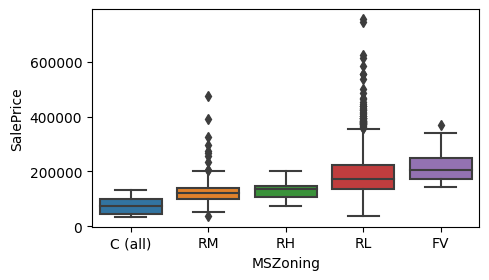

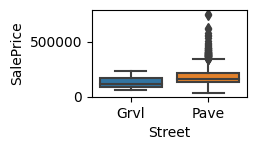

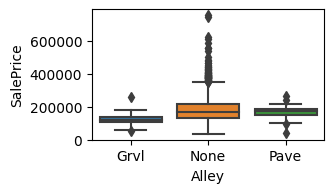

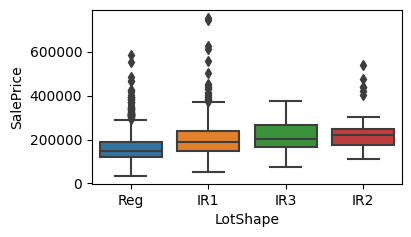

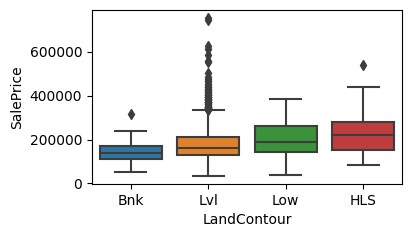

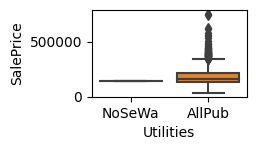

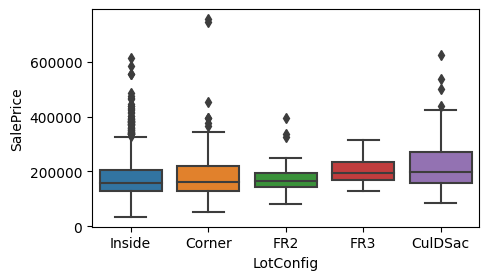

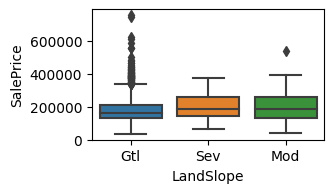

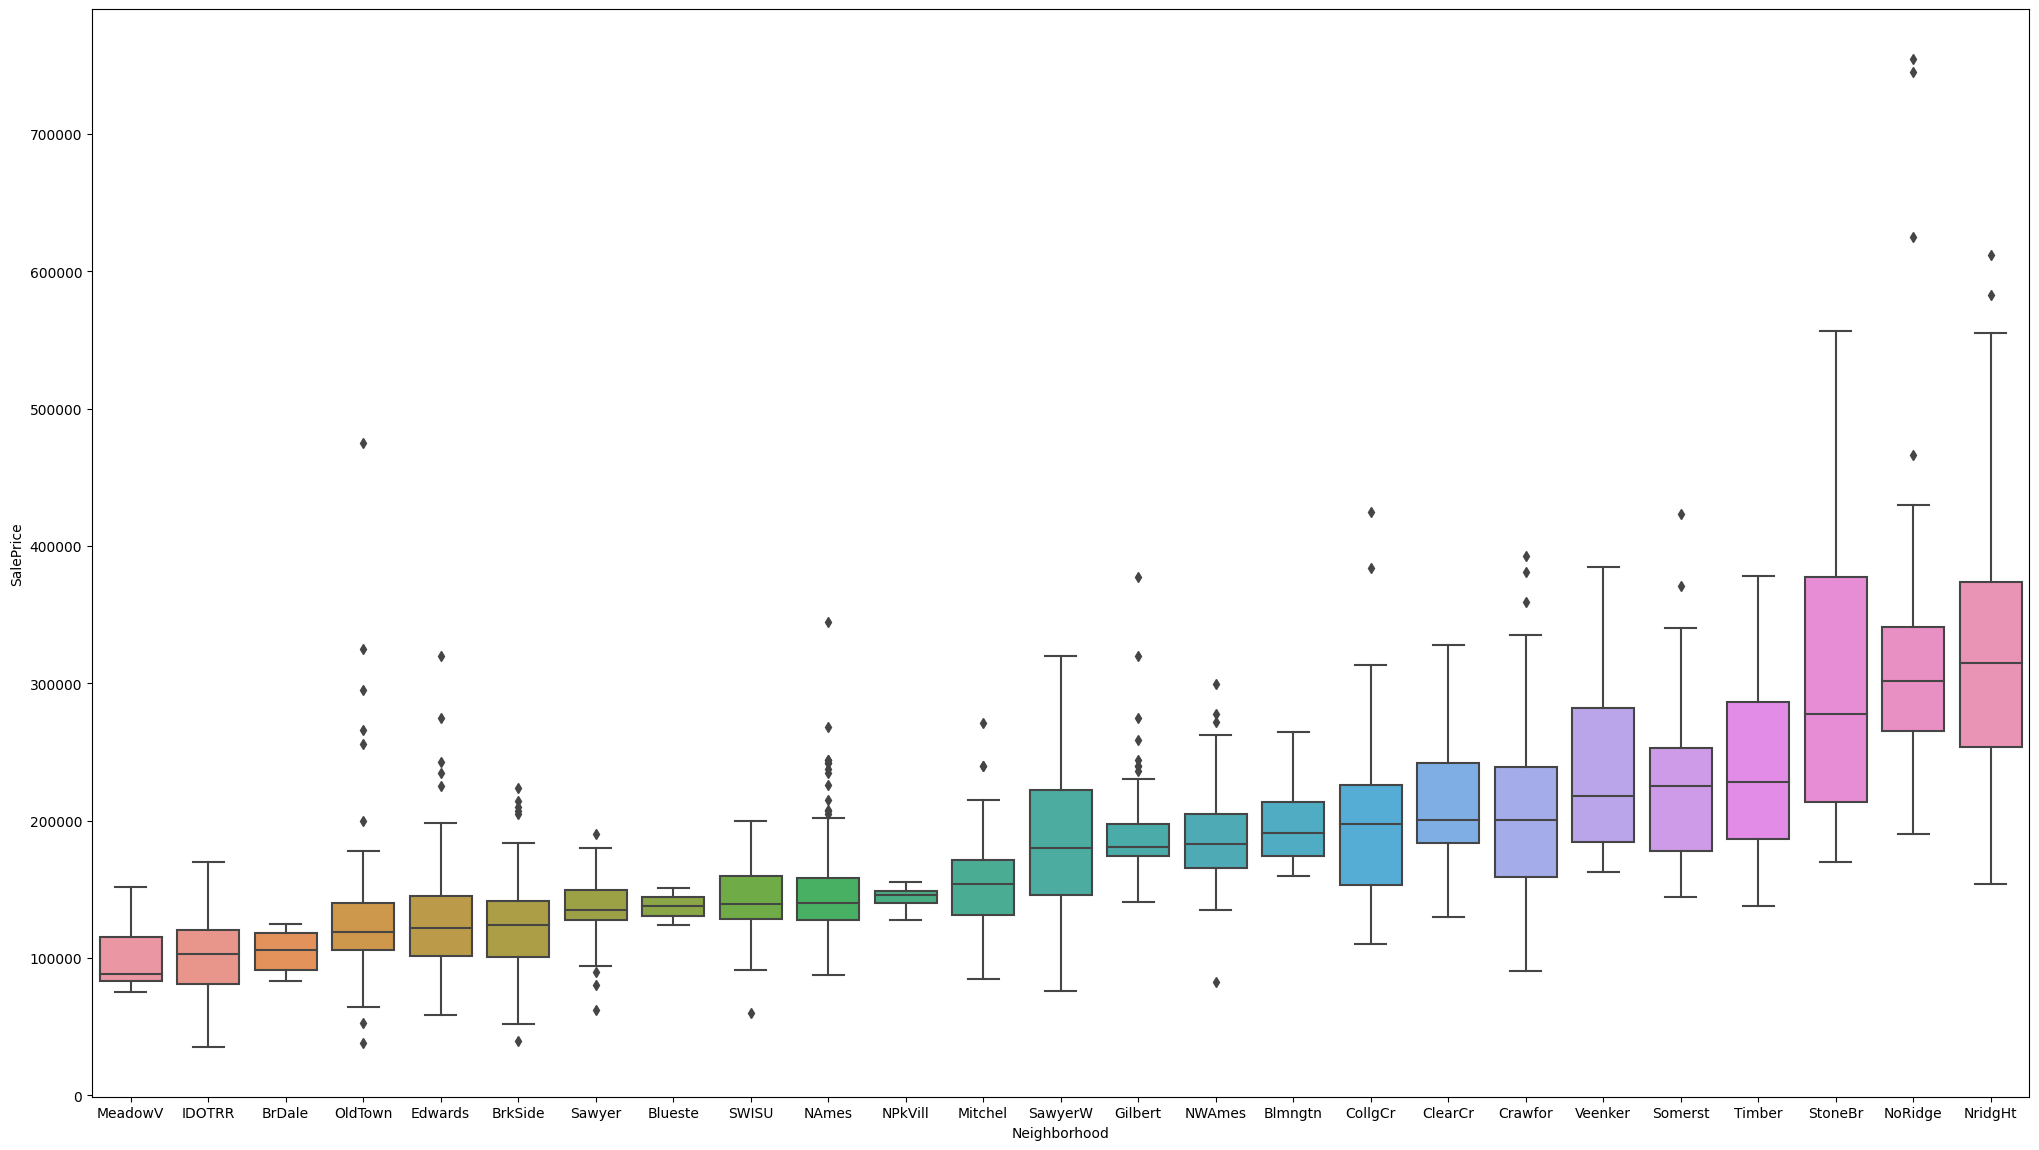

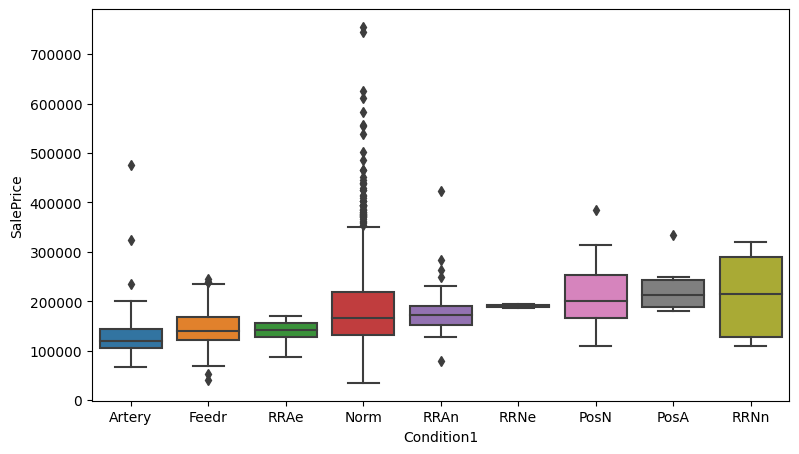

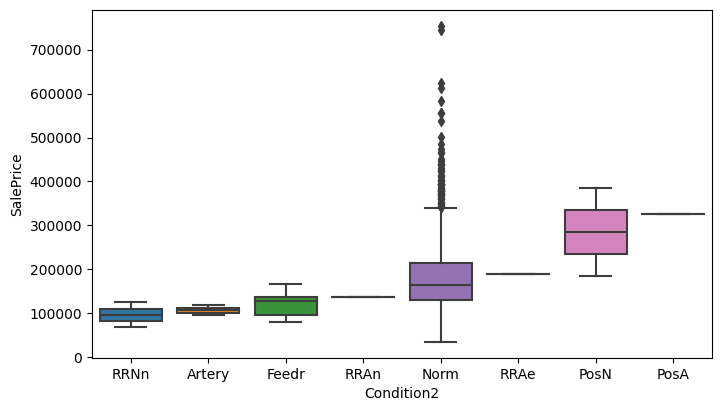

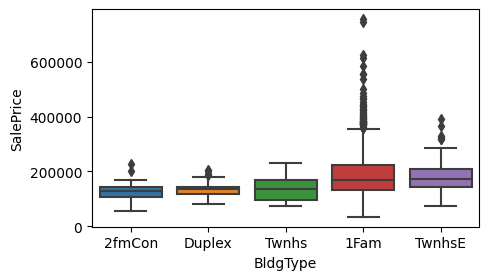

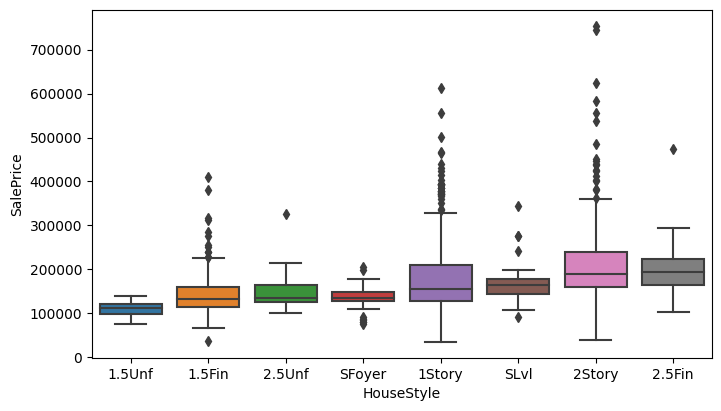

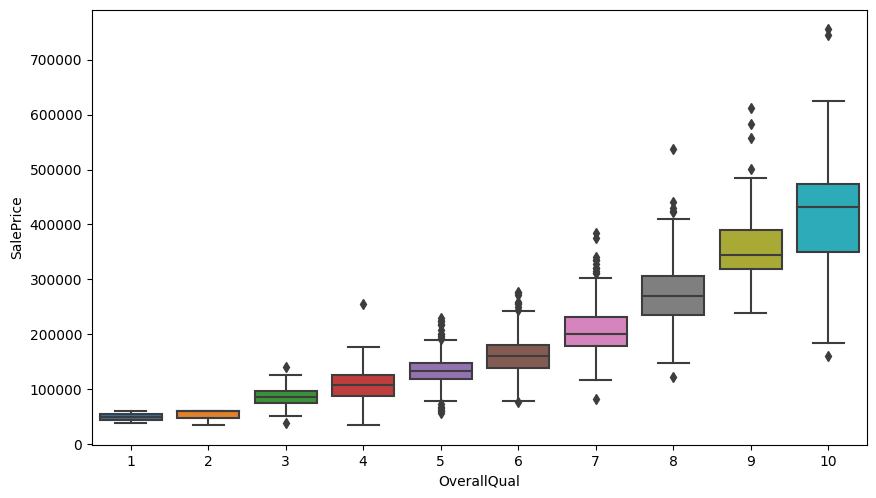

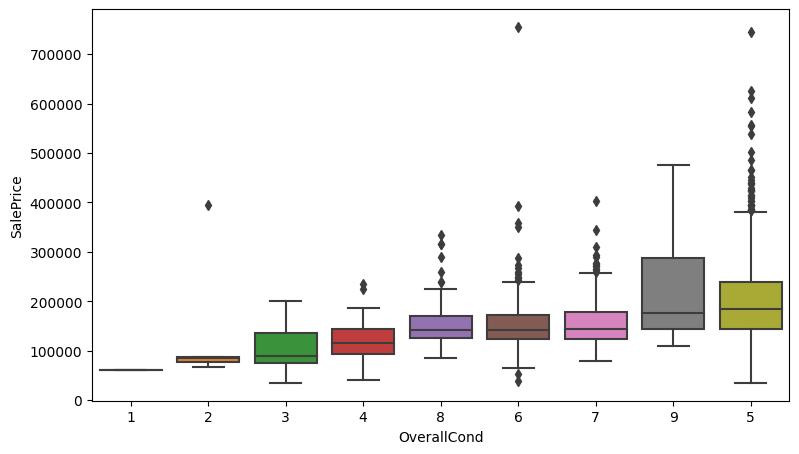

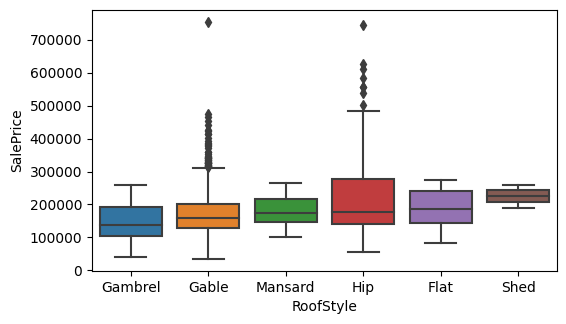

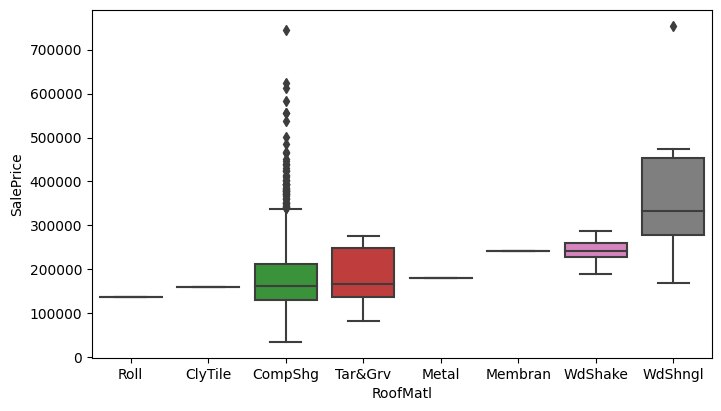

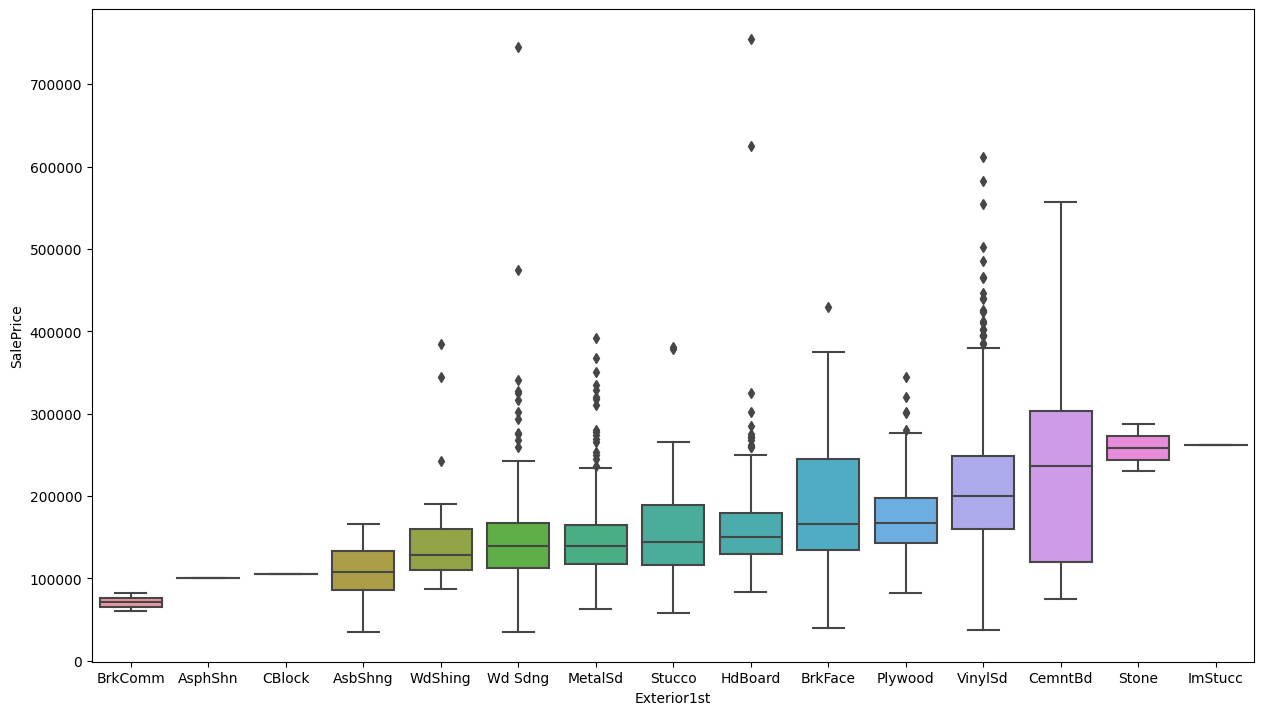

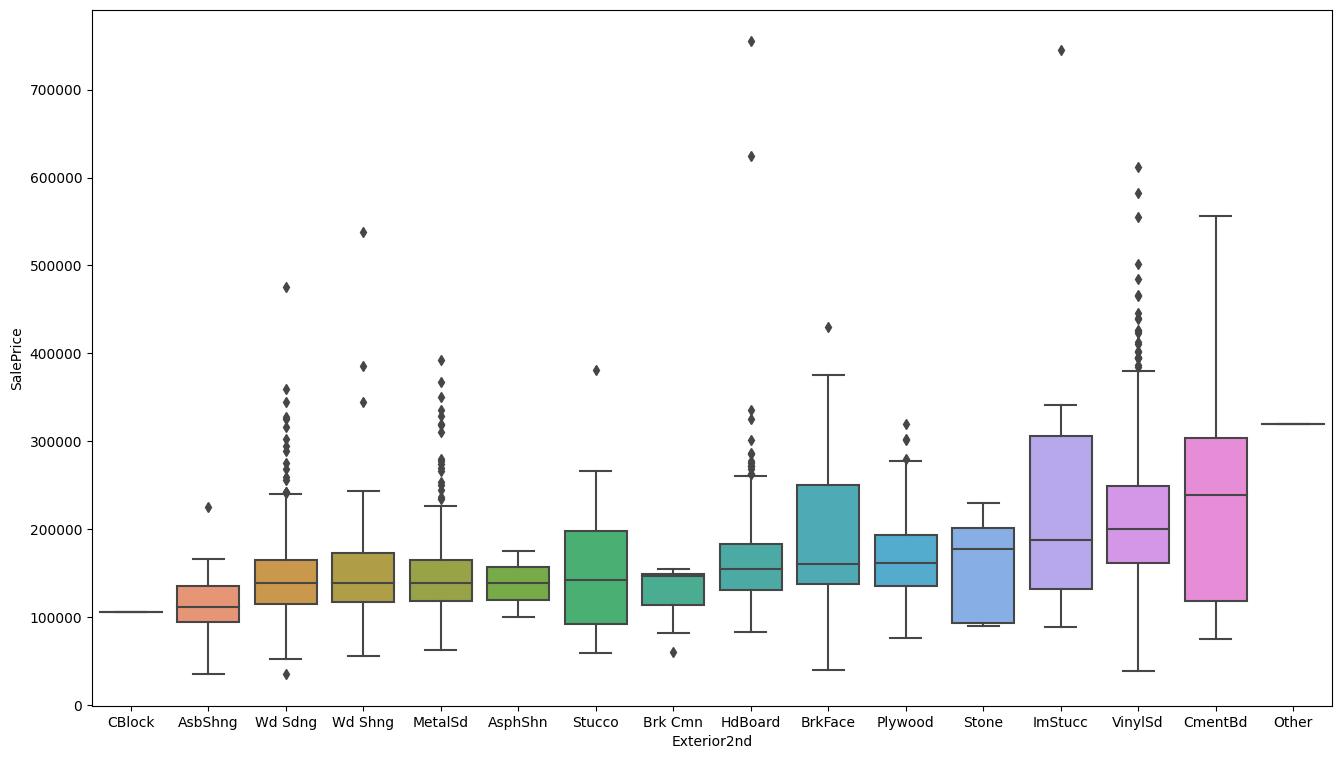

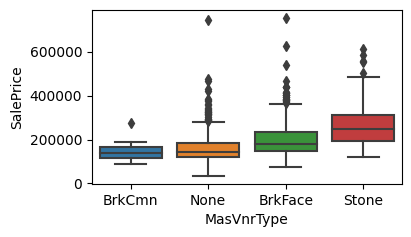

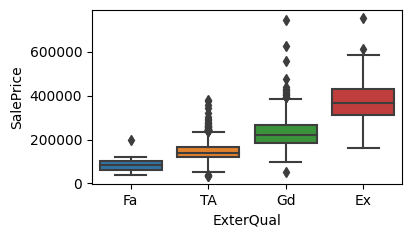

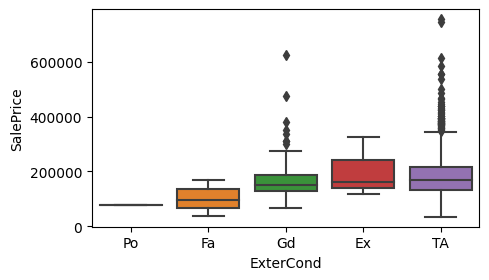

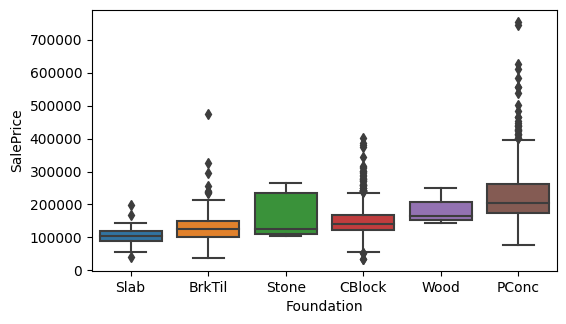

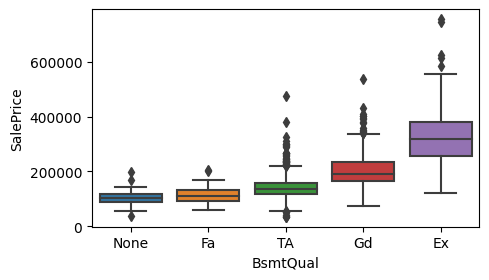

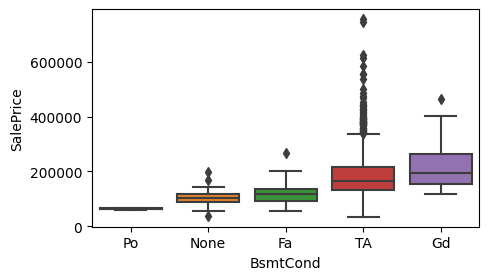

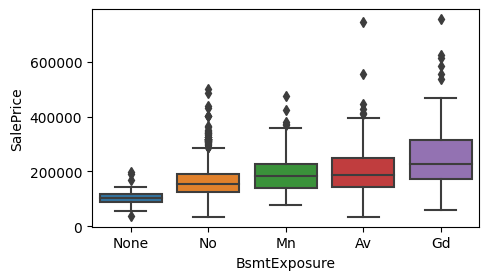

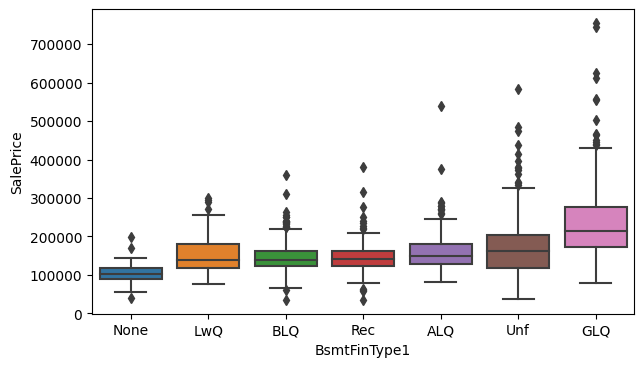

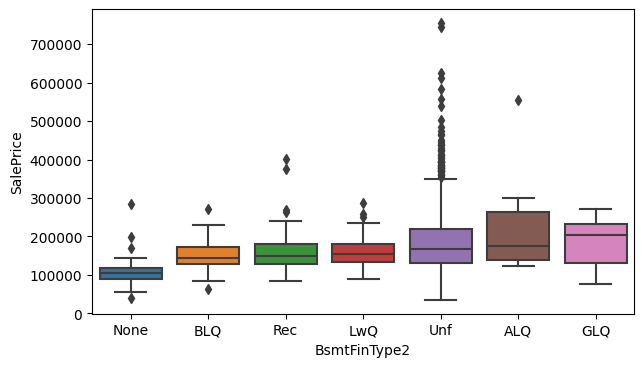

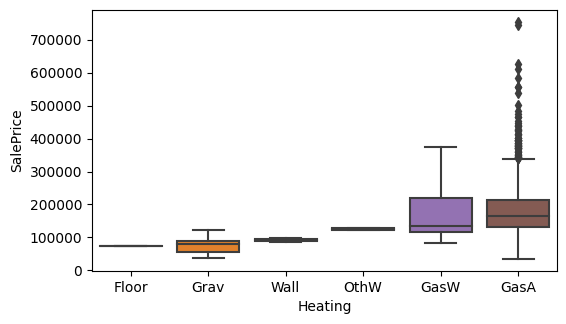

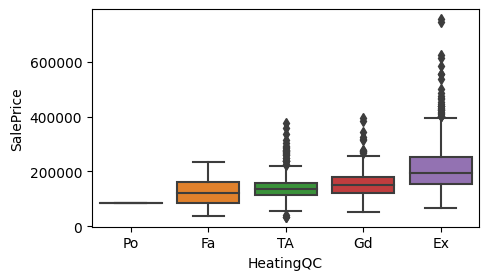

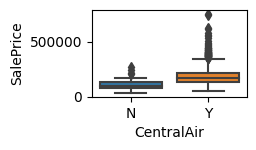

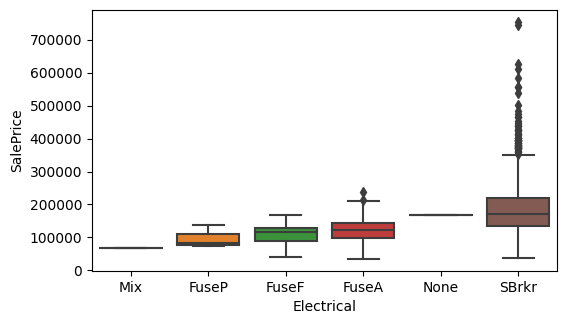

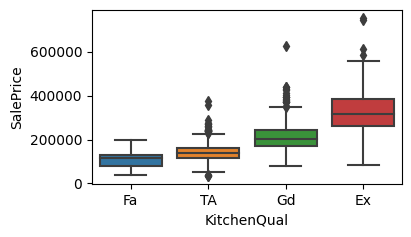

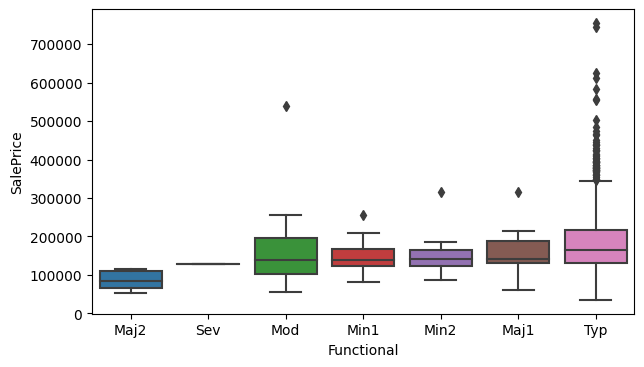

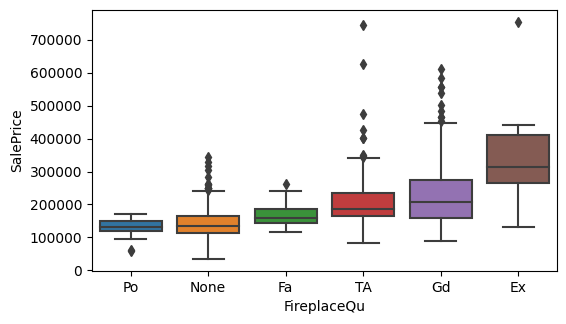

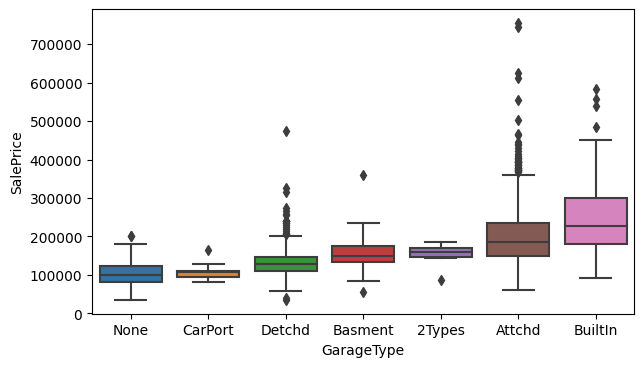

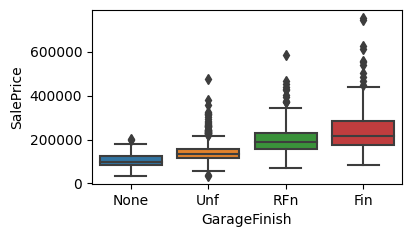

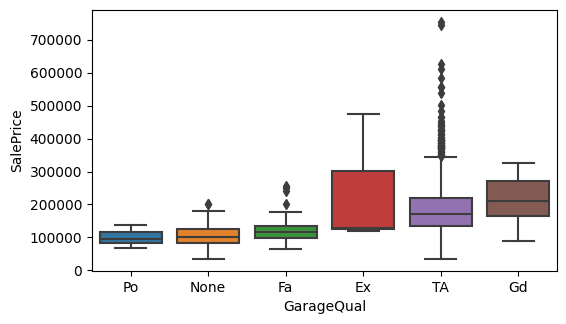

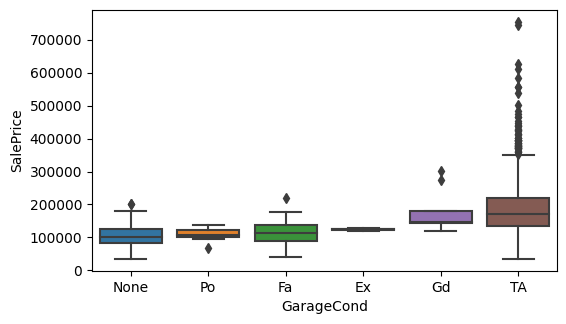

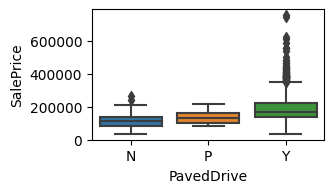

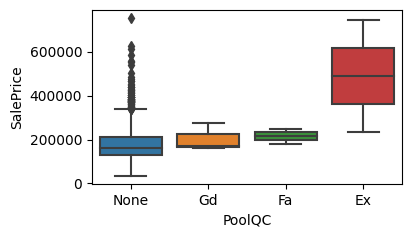

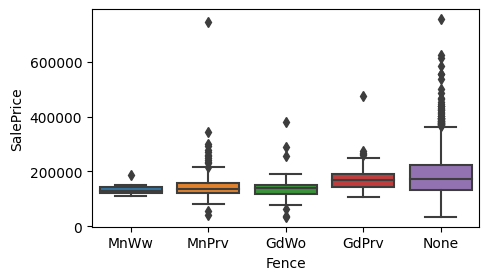

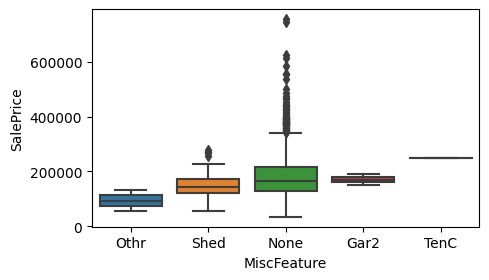

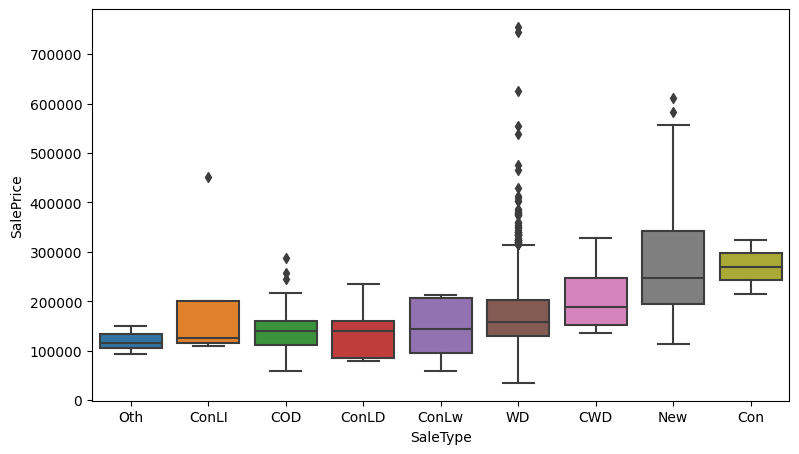

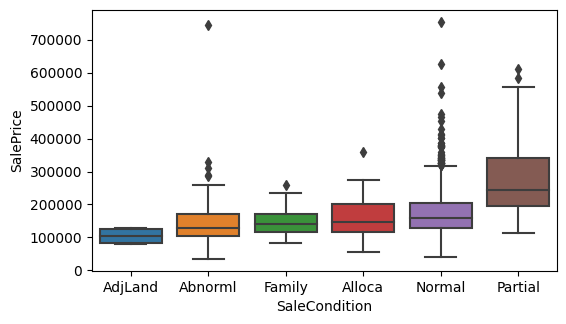

In [373]:
# CATEGORICAL COLUMN ANALYSIS
for i, col in enumerate(col_X_category):
    AnalyseCategoricalColumns(df_house, i, col, col_y)

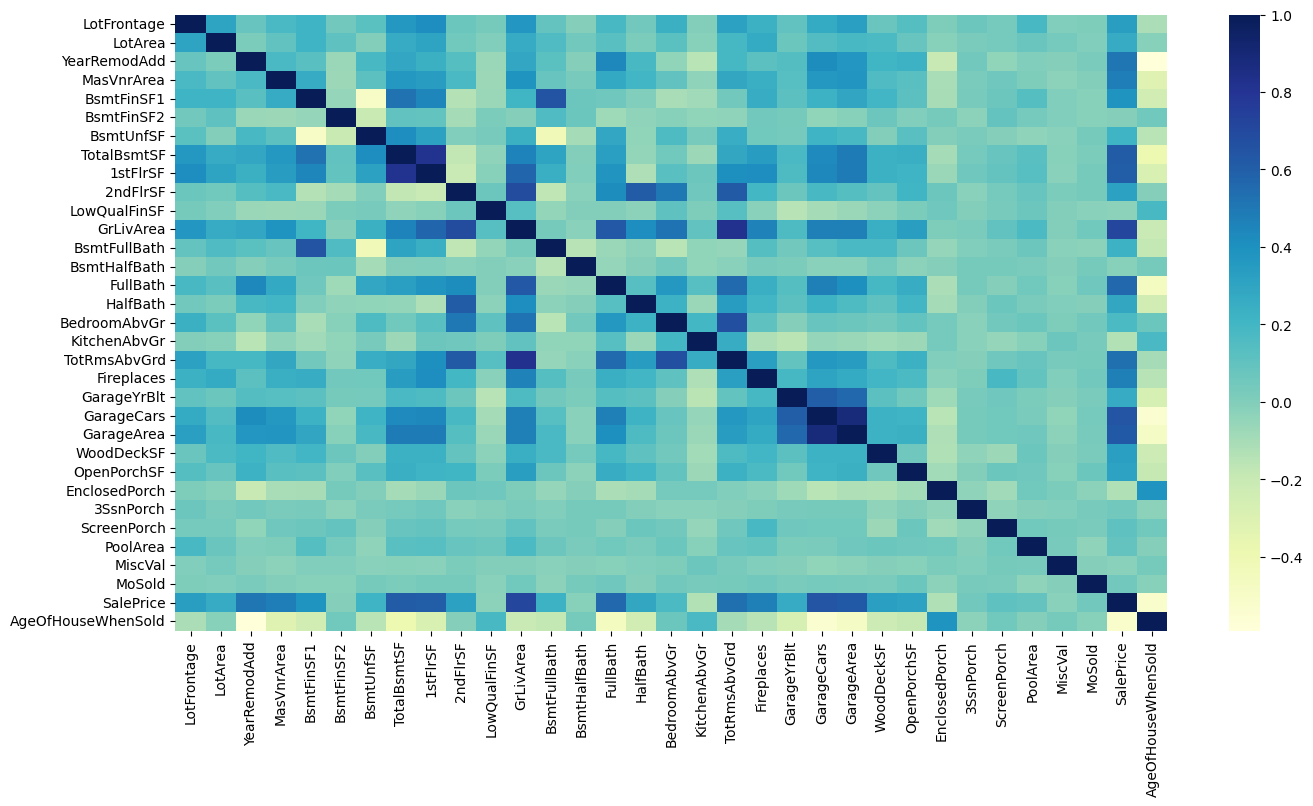

In [374]:
plt.figure(figsize=(16,8))
# heatmap
sns.heatmap(df_house.corr(), cmap="YlGnBu", annot=False)
plt.show()

In [375]:
df_house.drop(['GarageFinish', 'GarageQual', 'GarageCond','BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF'], axis=1, inplace=True)

# Summary
1. There is linear relationship between independent variable and output variable
2. There is collinearity between independent variables. Notice the darker shades of blue in the heatmap.

# **Data Prep for Modelling**

In [376]:
# Applying the function to the categorical columns
#df_house[['MoSold']] = df_house[['MoSold']].apply(MapMonths)
#df_house['MoSold'] = df_house['MoSold'].astype('category')

In [377]:
df_house.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,AgeOfHouseWhenSold
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,2,548,Y,0,61,0,0,0,0,None,None,None,0,2,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,2,460,Y,298,0,0,0,0,0,None,None,None,0,5,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,2,608,Y,0,42,0,0,0,0,None,None,None,0,9,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,3,642,Y,0,35,272,0,0,0,None,None,None,0,2,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,3,836,Y,192,84,0,0,0,0,None,None,None,0,12,WD,Normal,250000,8


### Create dummies for categorical fields

In [378]:
# Dumifying all columns of category type using a loop
#for col in col_X_category:
#    # Let's drop the first column from dummy df using 'drop_first = True' otherwise it will get multicollinear
#    dummies = pd.get_dummies(df_house[col], drop_first = True)
#    dummies = dummies.add_prefix(f'{col}_')
#    df_house = pd.concat([df_house, dummies], axis = 1)
#    # Drop original categorical column as we have created the dummies for it
#    df_house.drop([col], axis = 1, inplace = True)

#Create dummy columns for categorical variables and drop the first column
df_house = pd.get_dummies(df_house, drop_first=True)

df_house.info()
df_house.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 272 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(3), int64(27), uint8(242)
memory usage: 687.4 KB


,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfHouseWhenSold,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,Mi

In [379]:
# Preparing Test and Train Set

y = df_house.loc[:, col_y]
X = df_house.loc[:, df_house.columns != col_y]

# scale
scaler = StandardScaler()
scaler.fit(X)

## Splitting X and y into 80% train data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [380]:
# linear regression with all predictors
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict train
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
# predict test
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9419379695269348
0.20127208406338803


In [381]:
# Simple Linear Regression model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(3161302.75, 'PoolQC_None'),
 (-2527575.369, 'constant'),
 (-1251963.906, 'PoolQC_Gd'),
 (-904443.001, 'RoofMatl_Tar&Grv'),
 (-900572.047, 'RoofMatl_WdShake'),
 (-889663.319, 'RoofMatl_CompShg'),
 (-888784.092, 'RoofMatl_Roll'),
 (-868226.582, 'RoofMatl_WdShngl'),
 (-853099.531, 'RoofMatl_Metal'),
 (-745717.509, 'PoolQC_Fa'),
 (744853.051, 'MiscFeature_TenC'),
 (-234430.487, 'Condition2_PosN'),
 (101478.466, 'OverallQual_10'),
 (-86595.941, 'Condition2_RRAe'),
 (69953.135, 'RoofStyle_Shed'),
 (58953.813, 'OverallQual_9'),
 (-53300.855, 'Functional_Sev'),
 (-49025.851, 'Utilities_NoSeWa'),
 (-47420.934, 'LandSlope_Sev'),
 (37176.778, 'GarageType_CarPort'),
 (34753.506, 'HouseStyle_1.5Unf'),
 (32290.33, 'Neighborhood_StoneBr'),
 (31231.757, 'GarageType_Basment'),
 (31053.075, 'OverallQual_8'),
 (29734.647, 'GarageType_Detchd'),
 (29116.78, 'GarageType_Attchd'),
 (-28817.874, 'Heating_OthW'),
 (-28710.408, 'Neighborhood_MeadowV'),
 (28601.31, 'GarageType_BuiltIn'),
 (-27606.362, 'Neighbo

Summary:

Simple Linear Regression gave us a complex model with most of the coefficients as non-zero values.
Simple Linear Regression has not helped us in the feature selection.

# Ridge Regression

In [382]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,  0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,  4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()
# cross validation
folds = 5
cv_ridge_model = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1,
                        n_jobs=-1)
    
cv_ridge_model.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [383]:
cv_ridge_model.best_params_

{'alpha': 10.0}

In [384]:
# display the mean scores
ridge_cv_results = pd.DataFrame(cv_ridge_model.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=200]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
22,10.0,-14669.100129,-17937.868513,1
21,9.0,-14610.326001,-17957.041775,2
23,20,-15185.587102,-17966.477724,3
20,8.0,-14549.055150,-17984.355651,4
19,7.0,-14482.667897,-18026.832366,5
18,6.0,-14410.952832,-18088.442261,6
17,5.0,-14328.735287,-18172.867144,7
16,4.0,-14233.138339,-18273.907256,8
15,3.0,-14110.332326,-18416.059296,9
24,50,-16333.090450,-18564.671495,10


In [385]:
alpha = cv_ridge_model.best_params_["alpha"]
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

# predict
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred_ridge = ridge.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred_ridge))

0.8976525688919726
0.8777513621202192


In [386]:
# ridge model parameters
ridge_model_parameters = list(ridge.coef_)
ridge_model_parameters.insert(0, ridge.intercept_)
ridge_model_parameters = [round(x, 3) for x in ridge_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(ridge_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(-213888.179, 'constant'),
 (30876.124, 'OverallQual_9'),
 (25716.682, 'OverallQual_10'),
 (-24665.971, 'PoolQC_Gd'),
 (24588.805, 'Neighborhood_StoneBr'),
 (23431.034, 'Neighborhood_NoRidge'),
 (20742.59, 'Neighborhood_NridgHt'),
 (-20337.899, 'Condition2_PosN'),
 (17880.984, 'LandContour_HLS'),
 (-17668.417, 'BsmtQual_Gd'),
 (-17169.326, 'KitchenQual_TA'),
 (16793.185, 'Exterior2nd_ImStucc'),
 (-16292.732, 'KitchenQual_Gd'),
 (-16076.035, 'Neighborhood_Edwards'),
 (-15479.768, 'BsmtQual_TA'),
 (15051.478, 'Exterior1st_BrkFace'),
 (14465.31, 'BsmtExposure_Gd'),
 (-14343.745, 'KitchenAbvGr'),
 (14307.876, 'RoofMatl_WdShngl'),
 (13846.299, 'OverallCond_9'),
 (-13605.896, 'OverallQual_5'),
 (-13560.132, 'OverallCond_3'),
 (13200.807, 'HouseStyle_1Story'),
 (-13051.965, 'OverallQual_3'),
 (-12587.837, 'BldgType_Twnhs'),
 (12562.751, 'Neighborhood_Crawfor'),
 (-12357.529, 'OverallQual_6'),
 (-12321.346, 'OverallQual_4'),
 (-12266.052, 'BldgType_TwnhsE'),
 (11915.563, 'GarageCars'),
 (1151

# Perform Lasso Regression

In [387]:
lasso = Lasso()

# cross validation
cv_lasso_model = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

cv_lasso_model.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [388]:
cv_results = pd.DataFrame(cv_lasso_model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.345360,0.066020,0.009522,0.001283,0.0001,{'alpha': 0.0001},-20280.348042,-21203.026217,-18469.714631,-18269.160207,-20044.213896,-19653.292599,1119.318682,27,-11831.687884,-11377.003967,-11820.791090,-11599.481702,-11862.383029,-11698.269534,185.857918
1,0.330183,0.061506,0.010696,0.004687,0.001,{'alpha': 0.001},-20273.354168,-21202.827682,-18470.231077,-18268.586631,-20042.896208,-19651.579153,1118.423605,26,-11831.693090,-11376.981053,-11820.788063,-11599.454419,-11862.391926,-11698.261710,185.870659
2,0.323767,0.048909,0.007826,0.002045,0.01,{'alpha': 0.01},-20203.416033,-21200.759126,-18474.753810,-18262.851494,-20031.410526,-19634.638198,1110.027191,25,-11831.894424,-11376.917560,-11820.869911,-11599.362714,-11862.672687,-11698.343459,185.991658
3,0.312587,0.061826,0.008792,0.002006,0.05,{'alpha': 0.05},-19892.503446,-21191.976589,-18488.418700,-18244.545145,-19986.767248,-19560.842225,1080.253750,24,-11832.935892,-11376.703461,-11822.519564,-11598.972387,-11864.109409,-11699.048142,186.728462
4,0.439104,0.155644,0.019565,0.004276,0.1,{'alpha': 0.1},-19513.367222,-21180.843760,-18499.116060,-18249.130215,-19934.275144,-19475.346480,1056.164213,23,-11834.386833,-11376.776446,-11825.026066,-11598.658899,-11866.333245,-11700.236298,187.670611


In [389]:
# display the mean scores
ridge_cv_results = pd.DataFrame(cv_lasso_model.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=1000]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
24,50,-13298.417100,-17716.333317,1
25,100,-14237.120620,-17781.108318,2
23,20,-12460.689692,-17938.313220,3
22,10.0,-12096.186307,-18215.363001,4
21,9.0,-12058.675027,-18258.304657,5
20,8.0,-12021.238754,-18335.543100,6
19,7.0,-11980.272452,-18432.357708,7
18,6.0,-11938.839557,-18537.960271,8
17,5.0,-11895.814097,-18652.806548,9
16,4.0,-11854.673396,-18752.041048,10


In [390]:

alpha =cv_lasso_model.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 

# predict
y_train_pred = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred_lasso = lasso.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred_lasso))

0.9221037437318137
0.8679787331835458


In [391]:
# lasso model parameters
lasso_model_parameters = list(lasso.coef_)
lasso_model_parameters.insert(0, lasso.intercept_)
lasso_model_parameters = [round(x, 3) for x in lasso_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
lasso_selected_features = []
for k,v in sorted(list(zip(lasso_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)[1:31]:
    lasso_selected_features.append(v)
sorted(list(zip(lasso_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(-410771.9, 'constant'),
 (-309032.641, 'PoolQC_Gd'),
 (261279.649, 'PoolQC_None'),
 (-161207.861, 'Condition2_PosN'),
 (85784.222, 'OverallQual_10'),
 (-82336.615, 'PoolQC_Fa'),
 (55905.314, 'OverallQual_9'),
 (37759.939, 'Neighborhood_StoneBr'),
 (34675.45, 'SaleCondition_Alloca'),
 (27822.865, 'Neighborhood_NoRidge'),
 (24088.518, 'Neighborhood_NridgHt'),
 (23345.705, 'OverallQual_8'),
 (20945.686, 'Exterior1st_BrkFace'),
 (-20466.491, 'BldgType_Twnhs'),
 (19445.117, 'Neighborhood_Crawfor'),
 (-19147.0, 'BldgType_TwnhsE'),
 (-18229.589, 'OverallCond_3'),
 (17963.379, 'OverallCond_9'),
 (-17703.956, 'KitchenAbvGr'),
 (17622.26, 'SaleCondition_Partial'),
 (17525.939, 'Exterior2nd_ImStucc'),
 (-17148.835, 'KitchenQual_TA'),
 (16273.146, 'BsmtExposure_Gd'),
 (15979.165, 'RoofMatl_WdShngl'),
 (-15800.732, 'BsmtQual_Gd'),
 (15667.004, 'LandContour_HLS'),
 (-15554.879, 'KitchenQual_Gd'),
 (-14788.208, 'BsmtQual_TA'),
 (12633.218, 'Functional_Typ'),
 (11388.425, 'LotConfig_CulDSac'),
 (108

In [392]:
print(len(lasso_selected_features))

30


#RFE

In [393]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select = 30)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 226),
 ('LotArea', False, 239),
 ('YearRemodAdd', False, 218),
 ('MasVnrArea', False, 234),
 ('TotalBsmtSF', False, 230),
 ('1stFlrSF', False, 233),
 ('2ndFlrSF', False, 231),
 ('LowQualFinSF', False, 232),
 ('GrLivArea', False, 221),
 ('BsmtFullBath', False, 60),
 ('BsmtHalfBath', False, 167),
 ('FullBath', False, 8),
 ('HalfBath', False, 84),
 ('BedroomAbvGr', False, 177),
 ('KitchenAbvGr', False, 66),
 ('TotRmsAbvGrd', False, 73),
 ('Fireplaces', False, 46),
 ('GarageYrBlt', False, 235),
 ('GarageCars', False, 34),
 ('GarageArea', False, 229),
 ('WoodDeckSF', False, 236),
 ('OpenPorchSF', False, 240),
 ('EnclosedPorch', False, 237),
 ('3SsnPorch', False, 223),
 ('ScreenPorch', False, 225),
 ('PoolArea', False, 118),
 ('MiscVal', False, 238),
 ('MoSold', False, 206),
 ('AgeOfHouseWhenSold', False, 210),
 ('MSSubClass_30', True, 1),
 ('MSSubClass_40', False, 227),
 ('MSSubClass_45', False, 24),
 ('MSSubClass_50', False, 208),
 ('MSSubClass_60', False, 121),
 ('

In [394]:
ls_selected_col = X_train.columns[rfe.support_]
ls_selected_col

Index(['MSSubClass_30', 'LotShape_IR3', 'LandSlope_Sev', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Condition2_PosN', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10', 'RoofMatl_CompShg', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_CemntBd', 'Exterior1st_ImStucc', 'Exterior2nd_CmentBd', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_None', 'BsmtExposure_None', 'BsmtFinType2_None', 'Heating_Grav', 'Heating_OthW', 'PoolQC_Fa', 'PoolQC_None', 'SaleType_Con'], dtype='object')

In [395]:
lm = CreateLRModel(X_train, y_train,  ls_selected_col)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     105.1
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          4.13e-292
Time:                        10:38:48   Log-Likelihood:                -14057.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1139   BIC:                         2.832e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.099e+05 

In [396]:
lm =   CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     102.7
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          1.30e-298
Time:                        10:38:48   Log-Likelihood:                -14037.
No. Observations:                1168   AIC:                         2.814e+04
Df Residuals:                    1137   BIC:                         2.829e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.318e+

In [397]:
lasso_selected_features

['PoolQC_Gd',
 'PoolQC_None',
 'Condition2_PosN',
 'OverallQual_10',
 'PoolQC_Fa',
 'OverallQual_9',
 'Neighborhood_StoneBr',
 'SaleCondition_Alloca',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'OverallQual_8',
 'Exterior1st_BrkFace',
 'BldgType_Twnhs',
 'Neighborhood_Crawfor',
 'BldgType_TwnhsE',
 'OverallCond_3',
 'OverallCond_9',
 'KitchenAbvGr',
 'SaleCondition_Partial',
 'Exterior2nd_ImStucc',
 'KitchenQual_TA',
 'BsmtExposure_Gd',
 'RoofMatl_WdShngl',
 'BsmtQual_Gd',
 'LandContour_HLS',
 'KitchenQual_Gd',
 'BsmtQual_TA',
 'Functional_Typ',
 'LotConfig_CulDSac',
 'OverallCond_8']

In [401]:
lasso_selected_features.remove('PoolQC_None')
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     109.6
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          4.77e-294
Time:                        10:41:07   Log-Likelihood:                -14055.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1140   BIC:                         2.831e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.634e+

In [402]:
lasso_selected_features.remove('LandContour_HLS')
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     113.9
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          4.59e-295
Time:                        10:42:01   Log-Likelihood:                -14055.
No. Observations:                1168   AIC:                         2.816e+04
Df Residuals:                    1141   BIC:                         2.830e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.634e+

In [403]:
lasso_selected_features.remove('OverallCond_8')
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     118.6
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          4.60e-296
Time:                        10:44:49   Log-Likelihood:                -14055.
No. Observations:                1168   AIC:                         2.816e+04
Df Residuals:                    1142   BIC:                         2.829e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.632e+

In [404]:
lasso_selected_features.remove('OverallCond_9')
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     123.3
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          1.13e-296
Time:                        10:45:35   Log-Likelihood:                -14056.
No. Observations:                1168   AIC:                         2.816e+04
Df Residuals:                    1143   BIC:                         2.829e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.63e+

In [405]:
lasso_selected_features.remove('PoolQC_Fa')       
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     128.4
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          2.93e-297
Time:                        10:46:01   Log-Likelihood:                -14057.
No. Observations:                1168   AIC:                         2.816e+04
Df Residuals:                    1144   BIC:                         2.828e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.631e+

In [406]:
lasso_selected_features.remove('KitchenQual_Gd')         
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     133.9
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          9.51e-298
Time:                        10:46:31   Log-Likelihood:                -14059.
No. Observations:                1168   AIC:                         2.816e+04
Df Residuals:                    1145   BIC:                         2.828e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.699e+

In [407]:
lasso_selected_features.remove('RoofMatl_WdShngl')                
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     139.9
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          3.90e-298
Time:                        10:46:58   Log-Likelihood:                -14060.
No. Observations:                1168   AIC:                         2.816e+04
Df Residuals:                    1146   BIC:                         2.828e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.697e+

In [408]:
lasso_selected_features.remove('Exterior2nd_ImStucc')                    
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     146.3
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          2.53e-298
Time:                        10:47:20   Log-Likelihood:                -14063.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1147   BIC:                         2.827e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.699e+

In [409]:
lasso_selected_features.remove('SaleCondition_Alloca')                       
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     153.3
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          1.98e-298
Time:                        10:47:46   Log-Likelihood:                -14065.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1148   BIC:                         2.827e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.703e+

In [410]:
lasso_selected_features.remove('BsmtQual_TA')                                   
lm =  CreateLRModel(X_train, y_train, lasso_selected_features)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     160.3
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          9.06e-298
Time:                        10:48:06   Log-Likelihood:                -14069.
No. Observations:                1168   AIC:                         2.818e+04
Df Residuals:                    1149   BIC:                         2.827e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.596e+

In [411]:
lasso_selected_features

['PoolQC_Gd',
 'Condition2_PosN',
 'OverallQual_10',
 'OverallQual_9',
 'Neighborhood_StoneBr',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'OverallQual_8',
 'Exterior1st_BrkFace',
 'BldgType_Twnhs',
 'Neighborhood_Crawfor',
 'BldgType_TwnhsE',
 'OverallCond_3',
 'SaleCondition_Partial',
 'KitchenQual_TA',
 'BsmtExposure_Gd',
 'BsmtQual_Gd',
 'LotConfig_CulDSac']

In [412]:
lm.params

const                    159569.594108
PoolQC_Gd               -119090.402707
Condition2_PosN         -180788.089962
OverallQual_10           229863.504217
OverallQual_9            146905.347345
Neighborhood_StoneBr      50410.635801
Neighborhood_NoRidge      71142.857488
Neighborhood_NridgHt      47664.285761
OverallQual_8             61006.492547
Exterior1st_BrkFace       34232.060803
BldgType_Twnhs           -36538.264645
Neighborhood_Crawfor      40498.339254
BldgType_TwnhsE          -34004.592638
OverallCond_3            -39922.164187
SaleCondition_Partial     35031.108798
KitchenQual_TA           -28564.410008
BsmtExposure_Gd           34733.479915
BsmtQual_Gd               25292.644619
LotConfig_CulDSac         29090.879648
dtype: float64

In [415]:
y_train_price  = lm.predict(sm.add_constant(X_train[lasso_selected_features]))

Text(0.5, 0, 'Errors')

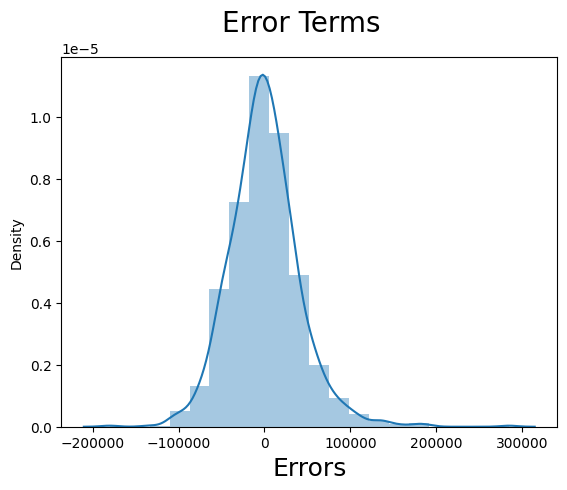

In [416]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price ), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

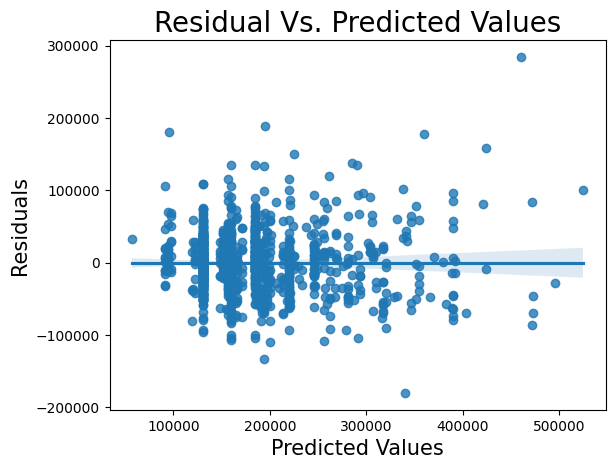

In [417]:
# Plot residuals against the predicted values
sns.regplot(x=y_train_price , y=(y_train - y_train_price ))
plt.title('Residual Vs. Predicted Values', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

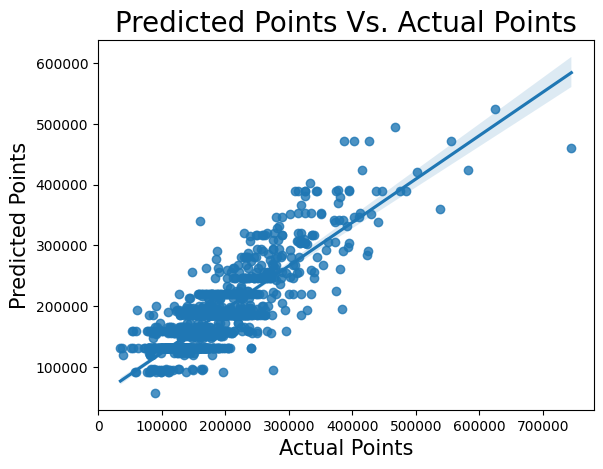

In [418]:
# Plot the predicted value against Actual data
sns.regplot(x=y_train, y=y_train_price )
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

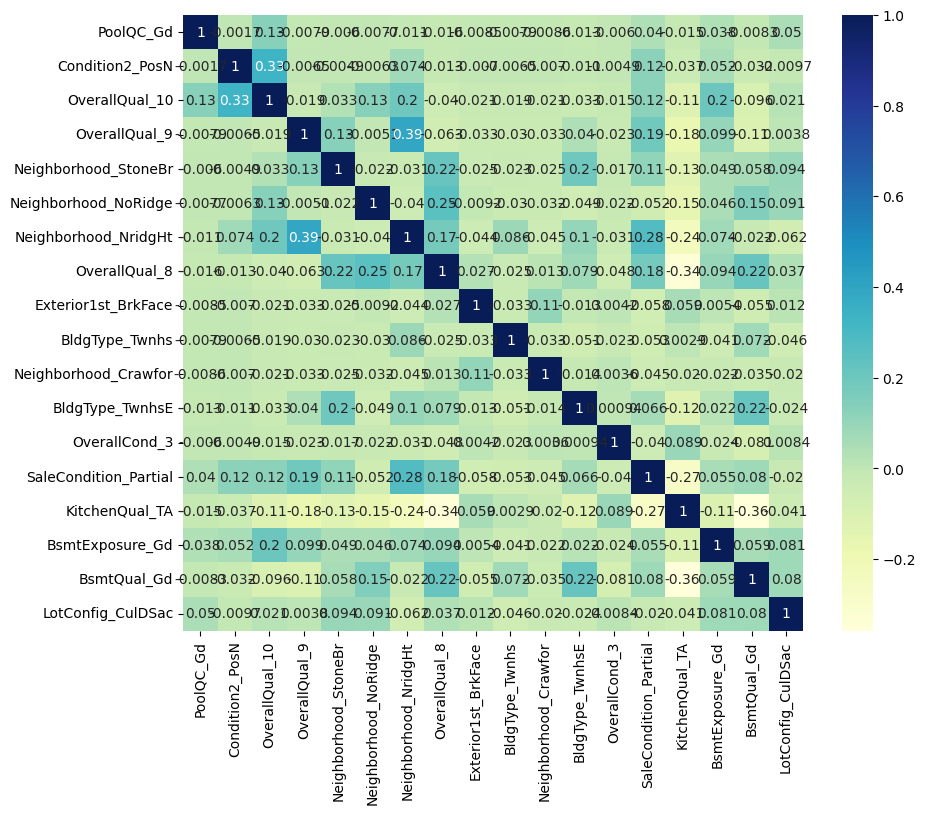

In [419]:
# Checking correlation between the predictors
plt.figure(figsize=(10,8))
# Heatmap
sns.heatmap(df_house[lasso_selected_features].corr(), cmap="YlGnBu", annot=True)
plt.show()